# Nonlinear regression

## Introduction

In the previous chapter, we explored the power of linear regression to uncover relationships between variables. But what happens when the relationship isn't a straight line? Many fascinating phenomena in biology, like how enzymes interact with substrates, how populations grow over time, or how organisms respond to drug doses, follow curves, not straight lines. This is where **nonlinear regression** comes into play.

Think of nonlinear regression as an extension of what we've already learned. It allows us to *fit any model where y is a function of X*, even when that *relationship is curved*. While the underlying math might be a bit more complex (involving some calculus and matrix algebra that we won't delve into here), the core idea remains the same: we want to *find the parameter values* that bring our model's predictions as close as possible to the actual data.

How does it achieve this? Nonlinear regression uses an **iterative** process, kind of like a series of educated guesses. We start with *initial estimates* for the **parameters**, which gives us a preliminary curve. Then, step-by-step, the method refines these parameters, adjusting the curve to better fit the data points. This continues until further adjustments no longer improve the fit.

In this chapter, we'll learn how to use Python to perform nonlinear regression, visualize the results, and interpret what they tell us about the biological processes we're studying. We'll even explore a powerful package called `lmfit` that makes working with these models even easier.

## Mathematical foundation

### Various nonlinear models

Before diving into the practicalities of fitting nonlinear models, let's take a closer look at some of the functions commonly used to describe biological phenomena. These functions provide the building blocks for our models, and understanding their shapes and properties will help us interpret the results of our analyses.

- **Exponential growth and decay:** we often encounter processes in biology where the rate of change is proportional to the current amount. This leads to exponential growth (e.g., bacterial population growth in ideal conditions) or decay (e.g., radioactive decay). The general form is:
  - Growth: $y = a  \exp(b X)$
  - Decay: $y = a \exp(-b X)$
  
  Where $a$ and $b$ are parameters controlling the **initial** value and the **rate** of growth/decay, respectively.

- **Logarithmic functions:** these functions describe relationships where the response variable changes slowly as the predictor variable increases. Examples include the relationship between species richness and habitat area or the response of sensory systems to stimuli. A common form is:
    - $y = a + b  \log(X)$

   Here, $a$ represents a **baseline** value, and $b$ determines the **rate** of change.

- **Power functions:** power functions capture relationships where one variable changes as a power of another. We see this in *allometric scaling*, where body size relates to metabolic rate, or in the relationship between the length and weight of an organism. The general form is:

   - $y = a  X^b$

   The parameter $a$ is a **scaling factor**, and $b$ determines the **power** relationship.

- **Michaelis-Menten kinetics:** this classic equation describes the rate of enzymatic reactions. It accounts for the saturation effect, where the reaction rate plateaus as the substrate concentration increases:

   - $y = \frac{V_\text{max} X}{K_m + X}$

   $V_\text{max}$ represents the **maximum** reaction rate, and $K_m$ is the Michaelis constant, indicating the substrate concentration at which *the reaction rate is half* of $V_\text{max}$.

The parameters in these equations have biological meaning. Estimating them allows us to quantify key aspects of the system we're studying. And once we have a well-fit model, we can use it to predict the response variable for new values of the predictor.

### A biological example

To illustrate how these functions apply to real-world research, let's revisit the [study by Frazier and colleagues](https://pubmed.ncbi.nlm.nih.gov/16736152/), which we encountered in earlier chapters. They investigated how norepinephrine affects muscle relaxation in the bladders of young and old rats. Their particular interest lay in understanding whether aging affects the maximum relaxation achievable with high doses of norepinephrine.

In this study, the authors measured muscle relaxation in response to varying concentrations of norepinephrine. They hypothesized that the relationship would follow a **sigmoidal** (S-shaped) curve, which is often observed in *dose-response studies*. To model this relationship, they used a modified version of the **Hill equation**, also known as the **4-parameter logistic (4PL)** model:

  $$y = y_0 + \frac{y_\text{max} - y_0}{1 + 10^{(\log{\text{EC}_{50}} - X) \cdot n_H}}$$

In this equation:

- $X$ is the **logarithm** of the norepinephrine concentration. Using the logarithm often helps linearize the relationship and improve model fitting
- $y$ is the muscle relaxation response (in %)

In nonlinear regression, the **parameters** are the key to unlocking the secrets hidden within our data. They are the values that define the shape and position of the curve, and they often have direct biological meaning:

- **Bottom ($y_0$):** this represents the **baseline** muscle relaxation when no norepinephrine is added. While we might *expect* this to be zero, it's crucial to let the data guide us. In some experiments, there might be a small degree of relaxation even without the drug, perhaps due to other factors at play. Therefore, we'll allow the model to estimate the $y_0$ parameter from the data, unless we have a strong justification to fix it to a specific value.

- **Top ($y_\text{max}$):** this parameter represents the maximum muscle relaxation, measured as %E<sub>max</sub>, achieved at high norepinephrine concentrations. A higher $\text{Top}$ value might indicate a greater potential for muscle relaxation in a particular group of individuals or under specific experimental conditions. In fact, this is precisely the kind of comparison we performed in the chapter on unpaired t-tests, where we assessed whether there was a significant difference in the mean %E<sub>max</sub> between the two age groups.

- **logEC<sub>50</sub>:** this parameter tells us about the sensitivity of the muscle to norepinephrine. A lower $\log{\text{EC}_{50}}$ means that a lower concentration of norepinephrine is needed to achieve half-maximal relaxation, indicating higher sensitivity. We might find that muscles from younger individuals have a lower $\log{\text{EC}_{50}}$ than those from older individuals, suggesting age-related changes in sensitivity to the neurotransmitter.

- **Hill slope ($n_H$):** this parameter, also called Hill coefficient, reflects how steeply the muscle relaxation increases with increasing norepinephrine concentration. A steeper slope suggests a more switch-like response, where a small change in concentration leads to a large change in relaxation. Differences in $n_H$ between experimental groups could indicate variations in the underlying mechanisms of norepinephrine action.

### Least squares estimation

Just like in linear regression, nonlinear regression relies on the principle of **least squares estimation**. But instead of fitting a straight line, we're now dealing with curves. Imagine we have a set of data points and a nonlinear function that we think describes the relationship between them. Our goal is to find the **parameter** values that make this function fit the data as closely as possible.

Least squares estimation aims to* minimize the sum of the squares* of the residuals, in other words, we want to find the parameter values that make the sum of the squared residuals as small as possible.

Mathematically, we can express this as finding the values of the parameters (like $y_0$, $y_\text{max}$, $\log{\text{EC}_{50}}$, and $n_H$ in our muscle relaxation example) that minimize the **weighted sum of squares**, often reprensented by the symbol $\chi^2$ (chi-squared):

$$\chi^2 = \sum_i^n{\frac{[y_i-y(x_i;a_k)]^2}{\epsilon_i}}$$

where $y_i$ is the observed value of the response variable for the $i$-th data point, $y(x_i; a_k)$ is the predicted value of the response variable based on our model with parameters $a_k$, and $\epsilon_i$ represents the estimated *uncertainty* associated with each data point. By including this in the denominator, we give less weight to data points with higher uncertainty, so they don't unduly influence the fit. This is the core principle of [**weighted least squares (WLS)**](https://en.wikipedia.org/wiki/Weighted_least_squares).

While the concept is similar to linear regression, finding the best-fit parameters in nonlinear models is a bit more involved. We can't simply solve an equation directly like we did for linear regression. Instead, we use an iterative process, where the algorithm starts with initial guesses for the parameters and gradually refines them to minimize χ².

One common approach is the **[gradient descent algorithm](https://en.wikipedia.org/wiki/Gradient_descent)**. Imagine you're trying to find the lowest point in a valley. Gradient descent is like taking small steps downhill, always moving in the direction of steepest descent, until you reach the bottom.

![grandient descent illustration](https://www.researchgate.net/profile/Konstantinos-Patlatzoglou/publication/364197638/figure/fig9/AS:11431281088359013@1665048829013/Gradient-descent-visualization-Amini-et-al-2018-At-each-training-step-epoch-the.png)

In our case, the "valley" represents the  χ<sup>2</sup>  surface, and the "lowest point" corresponds to the parameter values that minimize the sum of squared residuals.  The gradient descent algorithm starts with initial guesses for the parameters and then repeatedly updates them using this equation:

  $$a_{\text{next}} = a_{\text{cur}} + \gamma \sum_i^n{\frac{(y_i - y(x_i;a_k))}{\epsilon_i} \frac{\partial y}{\partial a_k}}$$

where:

- $a_{\text{next}}$ represents the updated value of the parameter in the *next* iteration
- $a_{\text{cur}}$ is the *current* value of the parameter
- $\gamma$ is a **step size** parameter that controls how big of a step we take in the direction of descent
- The remaining part of the equation essentially calculates the **direction** of steepest descent on the $\chi^2$ surface.

## Nonlinear regression in Python

### Exploring the data

Before we dive into the analysis, let's take a quick look at the data we'll be working with. This is always a good practice to get a sense of the relationships and potential issues.

One important assumption in nonlinear regression is that the *independent variable has minimal variability*. This means that we assume there's very little error in measuring or setting the independent variable (in our case, the norepinephrine concentration). This is often the case in designed experiments where we carefully control the independent variable.

Here's the data from Frazier et al., showing the muscle relaxation response to varying concentrations of norepinephrine.

In [126]:
import numpy as np

# Data from page 367
relaxation = np.array([2.6, 10.5, 15.8, 21.1, 36.8, 57.9, 73.7, 89.5, 94.7, 100, 100])
norepi_log = np.arange(-8, -2.5, .5)  # Log scale concentrations

Notice that we're working with the logarithm of the norepinephrine concentration ('norepi_log'). This is often done in dose-response studies because it can help linearize the relationship and improve model fitting.

Now let's visualize the data.

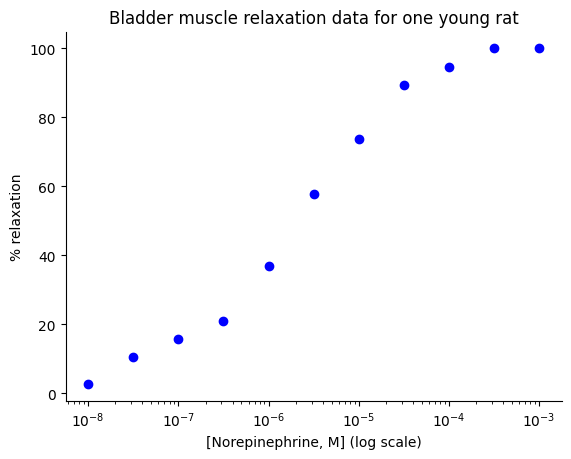

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

# For plotting, we'll need linear concentrations
norepi_lin = 10**norepi_log

# Create the plot
plt.plot(norepi_lin, relaxation, 'bo') 
plt.title("Bladder muscle relaxation data for one young rat")
plt.xlabel("[Norepinephrine, M] (log scale)")
plt.xscale('log') 
plt.ylabel(r"% relaxation")
sns.despine();

This plot gives us a visual representation of the relationship between norepinephrine concentration and muscle relaxation. We can clearly see the sigmoidal shape, suggesting that the Hill equation might be a suitable model for this data.

### Step-by-Step guide to using `curve_fit`

Now that we have a visual understanding of our data, let's use the [`curve_fit` function from the `scipy.optimize` library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) to fit the Hill equation.

#### Defining the model function

In Python, we can define **functions** to represent the mathematical equations we want to use for our models. These functions will take the independent variable $X$ ('norepi_log') and the necessary parameters as inputs and return the predicted values of the dependent variable $y$ ('relaxation').

Here's the general Hill equation (4PL model):

In [128]:
def hill_equation(x, bottom, top, logEC50, hill_slope):
    """
    This function defines the general Hill equation (4PL).

    Args:
      x: The logarithm of norepinephrine concentration.
      bottom: The baseline relaxation (Y0).
      top: The maximum relaxation (Ymax).
      logEC50: The logarithm of the EC50.
      hill_slope: The Hill slope (nH).

    Returns:
      The predicted relaxation values.
    """
    return bottom + (top - bottom) / (1 + 10**((logEC50 - x) * hill_slope))

Since we'll be working with a case where the 'bottom' is fixed at 0, let's define a separate function for that:

In [129]:
def hill_equation_bottom_zero(x, top, logEC50, hill_slope):
    """
    This function defines the Hill equation with bottom fixed at 0.

    Args:
      x: The logarithm of norepinephrine concentration.
      top: The maximum relaxation (Ymax).
      logEC50: The logarithm of the EC50.
      hill_slope: The Hill slope (nH).

    Returns:
      The predicted relaxation values.
    """
    return top / (1 + 10**((logEC50 - x) * hill_slope))

And here's a function for the **3PL model**, where the 'hill_slope' is fixed to 1:

In [130]:
def hill_equation_3pl(x, bottom, top, logEC50):
    """
    This function defines the 3-parameter logistic (3PL) equation.

    Args:
      x: The logarithm of norepinephrine concentration.
      bottom: The baseline relaxation (Y0).
      top: The maximum relaxation (Ymax).
      logEC50: The logarithm of the EC50.

    Returns:
      The predicted relaxation values.
    """
    return bottom + (top - bottom) / (1 + 10**(logEC50 - x))  # hill_slope is fixed to 1

By defining these separate functions, we make our code more modular and easier to understand. When we need to fit a specific model, we can simply call the corresponding function. This approach is good practice for organizing and maintaining scientific code which define particular mathematical equations.

#### Providing initial parameter guesses

Before we can fit our model, we need to provide **initial guesses** for the parameters. This is important because nonlinear regression algorithms often use **iterative** methods that start from these **initial values** and refine them step by step. Good initial guesses can help the algorithm **converge** faster and find the true best-fit solution.

But how do we come up with reasonable initial guesses?

- Visual inspection of the data: looking at the plot of the data, can we estimate the 'top' (maximum value), and the 'logEC50' (x-value where the response is halfway between 'top' and 'bottom')? What about the 'hill_slope' (how steep the curve is)?
- Prior knowledge or literature: do we have any prior information about the system we're studying? Perhaps there are published studies that report similar parameter values for related experiments. This knowledge can be invaluable in choosing realistic initial guesses. For example, we expect no relaxation in the absence of norepinephrine, which guides our decision to use the `hill_equation_bottom_zero` function where the 'bottom' (minimum value) is fixed at zero.
- Trial and error: if we're unsure, we can start with some reasonable guesses and see how the fit looks. If it's not good, we can adjust the initial guesses and try again.

Based on a visual inspection of the data, we're guessing that 'top' is around 100, 'logEC50' is around -6, and 'hill_slope' is around 1.

In [131]:
# Initial guess for the parameters (bottom is fixed to 0)
p0 = [100, -6, 1]  # Initial guesses for top, logEC50, and hill_slope

#### Fitting the model to the data

Now that we have our initial guesses, we can use `curve_fit` to find the best-fit parameters. `curve_fit` takes the following main arguments:

- The model function (in our case, `hill_equation_bottom_zero`)
- The independent variable data $X$ ('norepi_log')
- The dependent variable data $y$ ('relaxation')
- An optional initial guess for the parameters ('p0')

Here's how we can use `curve_fit` for our muscle relaxation data:

- `curve_fit`: it performs the nonlinear least squares optimization and returns two values:
  - 'best_vals': an *array* containing the best-fit values for the parameters ('top', 'logEC50', 'hill_slope' in this case)
  - 'covar': the estimated covariance matrix of the parameters, which we'll use later for calculating standard errors and confidence intervals
- Printing results: we print the best-fit values of the parameters, including the EC50 converted back to linear scale.

This code snippet performs the core nonlinear regression analysis, giving us the parameter estimates that best describe the relationship between norepinephrine concentration and muscle relaxation.

In [132]:
from scipy.optimize import curve_fit

# Fit the 4PL model to the data (bottom is fixed to 0 in the function definition)
best_vals, covar = curve_fit(
    hill_equation_bottom_zero,
    norepi_log,
    relaxation,
    p0=p0)

# Print the best-fit parameter values
print("Best-fit values of parameters (4PL model with fixed bottom):")
print("-----------------------------------------------------------")
print(f"top = {best_vals[0]:.1f}")
print(f"LogEC50 = {best_vals[1]:.2f}")
print(f"EC50 = {10**best_vals[1]:.2e}")
print(f"hill_slope = {best_vals[2]:.3f}")

Best-fit values of parameters (4PL model with fixed bottom):
-----------------------------------------------------------
top = 104.1
LogEC50 = -5.64
EC50 = 2.30e-06
hill_slope = 0.622


#### Extraction standard errors

As we just saw, `curve_fit` also returns 'covar', the *estimated covariance matrix* of the parameters from the last iteration of the fitting process. This matrix provides information about the variability of the estimated parameters and their relationships with each other. It can be represented in a general form like this:

$\Sigma = \begin{bmatrix}
  \sigma_1^2 & cov_{12} & \dots & cov_{1n} \\
  cov_{21} & \sigma_2^2 & \dots & cov_{2n} \\
  \vdots & \vdots & \ddots & \vdots \\
  cov_{n1} & cov_{n2} & \dots & \sigma_n^2
\end{bmatrix}$

where:

- $\sigma_i^2$ is the variance of the $i$-th parameter estimate
- $cov_{ij}$ is the covariance between the $i$-th and $j$-th parameter estimates

We encountered these terms in the chapters on correlation and simple linear regression. In the latter, the least squares method provided the standard error of the estimated coefficients as:

$s_{\hat{\beta}_j} = \sqrt{s^2 [(\mathbf{X}^T \mathbf{X})^{-1}]_{j,j}}$

where:
- $s^2$ is the estimated variance of the error term, also known as the **mean squared error (MSE)**, and calculated as $s^2 = \frac{\text{RSS}}{\text{DF}}$, where $\text{RSS}$ is the residual sum of squares and $\text{DF}$ is the degrees of freedom.
- $[(\mathbf{X}^T \mathbf{X})^{-1}]_{j,j}$ is the $j$-th diagonal element of the inverted $\mathbf{X}^T \mathbf{X}$ matrix, which represents the variance of the $j$-th coefficient estimate.

As we can see, the diagonal elements of this matrix provide the variances of the *parameter estimates*, which we'll use to calculate the standard errors.

In [133]:
# Calculate the standard errors of the parameters
standard_errors = np.sqrt(np.diag(covar))

# Print the standard errors
print("\nStandard errors of the parameters:")
print("----------------------------------")
print(f"Top: {standard_errors[0]:.2f}")
print(f"LogEC50: {standard_errors[1]:.3f}")
print(f"HillSlope: {standard_errors[2]:.4f}")


Standard errors of the parameters:
----------------------------------
Top: 2.06
LogEC50: 0.052
HillSlope: 0.0358


The standard errors give us a measure of the **uncertainty** in our parameter estimates. As we've learned in previous chapters, a larger standard error indicates greater uncertainty. To calculate the standard errors, we first extract the *diagonal elements of the covariance matrix*, which represent the **variances** of the parameters. Then, we take the square root of these variances.

Standard errors are crucial for assessing the reliability of our parameter estimates. They tell us how much the estimated parameters might vary due to random noise in the data. For instance, they play a role in *hypothesis tests* to determine whether a parameter is significantly different from a hypothesized value. We can also use the standard errors to construct *confidence intervals* around the parameter estimates, which we'll explore in a later section of this chapter.

## Advanced nonlinear regression with `lmfit`

In the previous section, we explored how to perform nonlinear regression using `scipy.optimize.curve_fit`. Now, let's introduce a powerful package called `lmfit` that offers several advantages and makes nonlinear regression even more flexible and intuitive.

[`lmfit` is a free and open-source Python library](https://lmfit.github.io/lmfit-py/) specifically designed for nonlinear least-squares minimization and curve fitting. It builds upon the foundation of `scipy.optimize` but provides a higher-level interface with many enhancements.

Here are some key advantages of using `lmfit`:

- **Parameter objects:** instead of working with plain numbers for parameters, `lmfit` uses 'Parameter' objects. These objects allow us to:
  - Give meaningful names to the parameters
  - [Set bounds and constraints on parameters](https://lmfit.github.io/lmfit-py/constraints.html) (e.g., force a parameter to be positive)
  - Easily fix parameters to constant values. For instance, we can use the general `hill_equation` function and fix the 'bottom' parameter to 0, effectively creating the `hill_equation_bottom_zero` functionality within `lmfit` itself
  - Define relationships between parameters (e.g., one parameter is always twice the value of another)
- **Improved model fitting:** provides a `Model` class that makes it easier to define and work with complex models. It also offers more robust fitting algorithms and better handling of difficult optimization problems.
- **Enhanced reporting:** provides more comprehensive fit statistics and diagnostic information, making it easier to assess the quality of your fit and identify potential issues.
- **Flexibility:** allows to easily switch between different fitting algorithms without changing your model definition.

We'll use `lmfit` in this chapter because it offers a more intuitive and powerful way to perform nonlinear regression, especially for complex models or when we need more control over the fitting process. It allows us to clearly define and manage our model parameters, set constraints and bounds on parameters, which can be important for ensuring biologically meaningful results, and access a wider range of fit statistics and diagnostic tools, simplifying the workflow and providing richer insights into our model.

### Setting parameter bounds and constraints

One of the powerful features of `lmfit` is the ability to set bounds and constraints on our parameters. This can be crucial for ensuring that our model results are biologically meaningful.

For example, in our muscle relaxation study, it doesn't make sense for the 'top' parameter (maximum relaxation) to be negative. Similarly, the 'hill_slope' parameter should ideally be positive, as a negative slope would imply that muscle relaxation decreases with increasing norepinephrine concentration, which is contrary to our expectations.

Moreover, by fixing 'bottom' to 0 within the general `hill_equation`, we provide a concrete illustration of how `lmfit` allows for flexible parameter handling. It shows that we can achieve the same result as defining a separate function (`hill_equation_bottom_zero`) but with more direct control within the `lmfit` framework.

In [134]:
from lmfit import Model

# Create a model object
model = Model(hill_equation)

# Create parameter objects, setting bounds and constraints
params = model.make_params(top=100, logEC50=-6, hill_slope=1)

# params['bottom'].value = 0  # Set initial value for bottom to zero
# params['bottom'].vary = False  # and fix it (behaves like in hill_equation_bottom_zero)
params.add('bottom', value=0, vary=False)  # Same as the two lines above

params['top'].min = 0  # top must be non-negative
params['hill_slope'].min = 0  # hill_slope must be non-negative

# Display the initial parameters set
params

name,value,initial value,min,max,vary
bottom,0.00000000,0,-inf,inf,False
top,100.000000,100.0,0.00000000,inf,True
logEC50,-6.00000000,-6.0,-inf,inf,True
hill_slope,1.00000000,1.0,0.00000000,inf,True


First, we create a `Model` object from our `hill_equation` function. Then, we create a 'Parameters' object, which allows us to set initial guesses and constraints for the model parameters. We use this object to:
- Fix the 'bottom' parameter to 0 by setting its value attribute to 0 and its vary attribute to `False`. This prevents it from being adjusted during the fitting process
- Set the 'min' attribute of the 'top' and 'hill_slope' parameters to 0, ensuring they cannot take negative values during the fitting process.

By setting the constraints we defined earlier, we ensure that the optimization algorithm explores only biologically plausible parameter values. This prevents the algorithm from getting stuck in unrealistic regions of the parameter space, leading to more meaningful and interpretable results. Ultimately, this increases our confidence that the fitted model accurately reflects the underlying biological process.

### Improved handling of complex models

`lmfit` offers significant improvements for handling complex models, including:

- Flexibility in model definition: the `Model` class allows for combining functions, defining parameter relationships, and handling intricate structures. For example, we can easily define a model that involves multiple interacting components or where one parameter is a function of another
- Choice of minimizers and robust algorithms: `lmfit` allows us to [choose from a variety of optimization algorithms (minimizers)](https://lmfit.github.io/lmfit-py/fitting.html#choosing-different-fitting-methods) to find the best-fit parameters, including more robust algorithms that can handle high-dimensional parameter spaces and challenging objective functions. This flexibility can be crucial for complex models where different algorithms might perform better depending on the shape of the objective function and the parameter space
- Better handling of parameter constraints: the 'Parameters' object provides a structured way to define constraints, ensuring biologically meaningful results
- Enhanced reporting and diagnostics: `lmfit` offers comprehensive fit statistics and diagnostic information to assess the quality of the fit and identify potential issues.

Now, let's use the `fit` method to fit the model to our data, using the 'Parameters' object and the independent variable data. We'll then display the optimized parameters.

In [135]:
# Fit the model to the data
result = model.fit(data=relaxation, x=norepi_log, params=params,)

# Display the optimized parameters
result.params

name,value,standard error,relative error,initial value,min,max,vary
bottom,0.00000000,0.00000000,,0,-inf,inf,False
top,104.053054,2.05947861,(1.98%),100.0,0.00000000,inf,True
logEC50,-5.63808943,0.05151637,(0.91%),-6.0,-inf,inf,True
hill_slope,0.62209892,0.03579809,(5.75%),1.0,0.00000000,inf,True


### Accessing richer fit statistics and diagnostics

One of the major advantages of `lmfit` is that it provides a wealth of information about the fit beyond just the parameter estimates. This information can help us assess the quality of the fit and identify potential issues.

Here's how we can access some of these statistics and diagnostics.

In [136]:
# Print the fit report
print(result.fit_report())

[[Model]]
    Model(hill_equation)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 11
    # variables        = 3
    chi-square         = 42.9570499
    reduced chi-square = 5.36963124
    Akaike info crit   = 20.9853605
    Bayesian info crit = 22.1790464
    R-squared          = 0.99712027
[[Variables]]
    bottom:      0 (fixed)
    top:         104.053054 +/- 2.05947861 (1.98%) (init = 100)
    logEC50:    -5.63808943 +/- 0.05151637 (0.91%) (init = -6)
    hill_slope:  0.62209892 +/- 0.03579809 (5.75%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(top, logEC50)        = +0.7796
    C(top, hill_slope)     = -0.6955
    C(logEC50, hill_slope) = -0.5410


The `fit_report` method prints a comprehensive report of the fit results, including:
- Best-fit parameter values and their *standard errors* (not the margin of error)
- Chi-squared value and reduced chi-squared
- Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC)
- R-squared
- Correlation matrix of the parameters

We can directly access specific fit statistics using attributes like `best_values`, `nfree`, `chisqr`, `redchi`, `aic`, `bic`, and `rsquared`. Similar to `curve_fit`, the `covar` attribute in the SciPy optimization result holds the covariance matrix of the parameters. From this, we can calculate the correlation matrix, which can help us identify potential issues with parameter identifiability.

By taking advantage of these richer fit statistics and diagnostics, we can gain a deeper understanding of our nonlinear regression models and make more informed conclusions about the biological processes we're studying.

In [137]:
# Access specific fit statistics
print(f"Best-fit values: ", result.best_values)  # Returns a dictionnary
print(f"DF: {result.nfree:n}")
print(f"Absolute sum of squares (χ²): {result.chisqr:.2f}")
print(f"Reduced chi-squared: {result.redchi:.2f}")
print(f"Akaike Information Criterion (AIC): {result.aic:.2f}") # type: ignore
print(f"Bayesian Information Criterion (BIC): {result.bic:.2f}") # type: ignore
print(f"R²: {result.rsquared:.3f}")

# Access parameter correlation matrix
print("\nParameter correlation matrix:")
print(result.covar)

Best-fit values:  {'bottom': 0, 'top': 104.05305410668639, 'logEC50': -5.638089431195984, 'hill_slope': 0.6220989155826002}
DF: 8
Absolute sum of squares (χ²): 42.96
Reduced chi-squared: 5.37
Akaike Information Criterion (AIC): 20.99
Bayesian Information Criterion (BIC): 22.18
R²: 0.997

Parameter correlation matrix:
[[ 4.24145214e+00  8.27134462e-02 -5.12779994e-02]
 [ 8.27134462e-02  2.65393682e-03 -9.97621974e-04]
 [-5.12779994e-02 -9.97621974e-04  1.28150323e-03]]


The 'result' attribute provides a more structured representation of the fit results, including the optimized parameters, their standard errors, and other statistics. This can be useful for programmatically accessing specific values or for a more compact presentation of the results.

In [138]:
# Access and display the fit results using result.result
result.result

### Predicting values

When using `scipy.optimize.curve_fit`, we can use the best-fit parameters obtained from the fit, along with the original equation (defined as a Python function), to predict values.

For example, let's say we want to predict the muscle relaxation response for a 'log[Norepinephrine]' value of -6.0. We can use the `hill_equation_bottom_zero` function and the 'best_vals' obtained from `curve_fit` to calculate this prediction.

In [139]:
# Predict the y-value for a new x-value using curve_fit results
new_x = -6.0  # Example: log[Norepinephrine] = -6.0
predicted_y = hill_equation_bottom_zero(new_x, *best_vals)  # Use * to unpack parameter values

print(f"Predicted y-value for x = {new_x}: {predicted_y:.2f}%")

Predicted y-value for x = -6.0: 38.84%


In this code, the asterisk (`*`) before 'best_vals' is used to unpack the elements of the array and pass them as individual arguments to the `hill_equation_bottom_zero` function. This is necessary because the function expects the parameter values as separate arguments, not as a single array.

Similarly, we can use two asterisks (`**`) to unpack the 'result.params' dictionary with `lmfit`. This passes the key-value pairs of the dictionary as keyword arguments to the `hill_equation` function. This is necessary because the function expects the parameter values as separate keyword arguments with their corresponding names, not as a single dictionary. Note that we use the original `hill_equation` function here because the 'result.params' dictionary includes the 'bottom' parameter, which is not present in the `hill_equation_bottom_zero` function.

In [140]:
# Predict the y-value for a new x-value using lmfit best-fit paramters
new_x = -6.0  # Example: log[Norepinephrine] = -6.0
predicted_y = hill_equation(new_x, **result.params)  # Use ** to unpack parameter values

print(f"Predicted y-value for x = {new_x}: {predicted_y:.2f}%")

Predicted y-value for x = -6.0: 38.84%


With `lmfit`, we can use the [`eval()` method](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model.eval) of the 'result' object to predict values. This method takes the independent variable (`x`) as an argument, along with any parameter values we want to specify.

In [141]:
# Predict the y-value for a new x-value using lmfit result
new_x = -6.0  # Example: log[Norepinephrine] = -6.0
predicted_y = result.eval(x=new_x)

print(f"Predicted y-value for x = {new_x}: {predicted_y:.2f}%")

Predicted y-value for x = -6.0: 38.84%


If we don't specify a parameter value in `result.eval()`, it uses the optimized value from the fit. Interestingly, it also appears to use the independent variable from the fitting data, even if we don't explicitly provide it as an argument.

In [142]:
# Predict the y-values
result.eval()

array([  3.41522451,   6.75770945,  12.95052424,  23.45062827,
        38.83501989,  57.15534876,  74.275411  ,  87.00942425,
        94.96425495,  99.40465299, 101.7287595 ])

## Assessing the goodness of fit

We've now explored how to use both `curve_fit` and `lmfit` to fit nonlinear models to our data. But how do we know if the model we've chosen is actually a *good* fit? This is where assessing the **goodness of fit** comes in.

Goodness of fit refers to how well our model describes the observed data. A good fit means that the model's predictions closely match the actual data points, while a poor fit indicates that the model doesn't accurately capture the relationship between the variables.

Why is assessing goodness of fit important?

- Confidence in conclusions: a good fit gives us more confidence that our model accurately reflects the underlying biological process and that our conclusions based on the model are reliable
- Model selection: if we're comparing different models, goodness of fit can help us choose the model that best describes the data.
- Identifying potential issues: assessing goodness of fit can help us identify potential problems with our model, such as:
  - Model misspecification: the chosen model might not be the right one for the data
  - Outliers: there might be unusual data points that are influencing the fit
  - Non-constant variance: the variability of the data might not be constant across the range of the independent variable

### Residual analysis in nonlinear regression

Just like in linear regression, one of the most effective ways to assess the goodness of fit of a nonlinear regression model is to examine the **residuals**. Remember that residuals are the differences between the observed data points and the values predicted by the model. They represent the "unexplained" variation in the data that the model doesn't account for.

By analyzing the residuals, we can gain valuable insights into whether our model is a good fit for the data and identify potential areas for improvement.

#### Plotting residuals vs. predicted values

A common and informative way to visualize **residuals** is to create a scatter plot of residuals on the y-axis against the corresponding **predicted** values on the x-axis. This type of plot can reveal patterns in the residuals that might indicate problems with the model, just as we saw in the context of linear regression.

To obtain the predicted values, we can use the `result.best_fit` attribute of the 'result' object. This attribute holds the values of the relaxation response that our model predicts for each norepinephrine concentration used in the experiment. Alternatively, the 'result' object also provides the residuals directly.

In [143]:
# Calculate the residuals
residuals = result.best_fit - relaxation  # result.best_fit holds the predicted values from the fitted model
# residuals = result.residual  # Same as above

Note that the sign of the residuals might be reversed depending on whether we calculate them as *(data - model)* or *(model - data)*. However, the absolute distances of the residuals from the horizontal line, and therefore the sum of squares, will be identical.

To create a residuals vs. predicted values plot, we can either extract the predicted values from the model (`result.best_fit`) and plot them against the residuals we calculate manually, or we can use the convenient `result.plot_residuals()` method provided by `lmfit`. By default, this method uses the independent variable on the x-axis, but we can modify this behavior by providing the `x=` parameter with the predicted values.

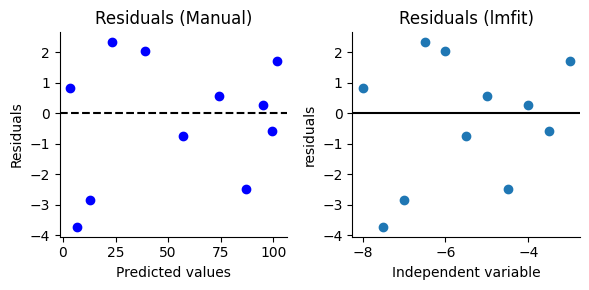

In [144]:
# Create the residuals vs. predicted values plot manually
fig, axes = plt.subplots(1, 2, figsize=(6, 3))  # Create figure and axes objects

# Manual plot on the left subplot
axes[0].plot(result.best_fit, residuals, 'bo')
axes[0].axhline(y=0, color='black', linestyle='--')
axes[0].set_xlabel("Predicted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals (Manual)")

# lmfit plot on the right subplot
result.plot_residuals(ax=axes[1])  # Provide axes object
axes[1].set_xlabel("Independent variable")
axes[1].set_title("Residuals (lmfit)")

sns.despine()
plt.tight_layout();

#### Examining Patterns in Residuals to Identify Potential Issues

Ideally, in a well-fit model, the residuals should be randomly scattered around the horizontal line at y=0, with no discernible patterns. If we observe any systematic patterns in the residuals, it can indicate problems with our model. Here are some common patterns to watch out for and what they might suggest:

- *Curvature*: if the residuals show a curved pattern, it might suggest that the model is misspecified. This means that the functional form we've chosen (in our case, the Hill equation) doesn't accurately capture the true relationship between the variables. We might need to consider a different type of nonlinear function or add more terms to our existing model to better capture the curvature.
- Non-constant variance (*heteroscedasticity*): if the spread of the residuals increases or decreases systematically across the range of predicted values, it indicates non-constant variance. This violates one of the assumptions of nonlinear regression, which is that the variability of the data should be constant across the range of the independent variable. Non-constant variance can affect the reliability of our parameter estimates and confidence intervals. We might need to transform the data or use weighted regression techniques to address this issue.
- *Outliers*: individual points that lie far from the general pattern of residuals might be outliers. These points can have a disproportionate influence on the fit and can distort the parameter estimates. It's important to investigate outliers to determine if they are due to data entry errors, measurement problems, or truly unusual observations. If we identify valid outliers, we might need to consider robust regression techniques that are less sensitive to outliers.
- *Autocorrelation*: in some cases, especially with time-series data, the residuals might show autocorrelation, meaning that adjacent residuals are correlated with each other. This violates the assumption of independence of errors and can affect the validity of our statistical inferences. We might need to use specialized time-series models or account for the autocorrelation in our analysis.

By carefully examining the residuals vs. predicted values plot and looking for these patterns, we can gain valuable insights into the adequacy of our nonlinear regression model and identify potential areas for improvement. It's important to remember that residual analysis is an iterative process. If we identify issues, we might need to adjust our model, transform the data, or use different analysis techniques to achieve a better fit.

### Calculating R-squared

In linear regression, we often use the **R² (R-squared)** value as a measure of goodness of fit. It represents the proportion of variance in the dependent variable that's explained by the model. However, in nonlinear regression, R-squared has some limitations and should be interpreted with caution.

While there isn't a single universally accepted definition of R² for nonlinear models, one common approach is to calculate it as:

$$R^2 = 1 - \frac{\text{RSS}}{\text{TSS}}$$

where $\text{RSS}$ is the sum of squared errors (residuals), and $\text{TSS}$ is the total sum of squares, calculated as the sum of squared differences between the observed data points and the mean of the dependent variable. Notice that the RSS calculated here should be the same as the 'result.chisqr' value provided by `lmfit`. While both refer to the sum of squared residuals, it's important to note that this differs from the general chi-squared statistic we saw in the previous section, which incorporates weights based on the uncertainties of the data points.

This formula is analogous to the one used in linear regression. In fact, we can use the `compute_rss()` function we defined in the previous chapter on linear regression to calculate the RSS for our nonlinear model.

In [145]:
# Define functions to compute RSS and estimate y
def compute_rss(y_estimate, y):
    return sum(np.power(y - y_estimate, 2))

# Calculate RSS using the compute_rss() function from the previous chapter
rss = compute_rss(result.best_fit, relaxation)

# Calculate TSS
tss = np.sum(np.power(relaxation - np.mean(relaxation), 2))

# Calculate and print R-squared
print(f"TSS (manual):\t{tss:.2f}")
print(f"RSS (manual):\t{rss:.5f}")
print(f"χ² (lmfit):\t{result.chisqr:.5f}")
print("-"*24)
print(f"R² (manuel):\t{1 - rss/tss:.4f}")
print(f"R² (lmfit):\t{result.rsquared:.4f}")

TSS (manual):	14917.02
RSS (manual):	42.95705
χ² (lmfit):	42.95705
------------------------
R² (manuel):	0.9971
R² (lmfit):	0.9971


It's important to be aware of the limitations of R² in the nonlinear context:

- Not always interpretable as proportion of variance explained: in nonlinear models, R² doesn't always strictly represent the proportion of variance explained. This is because the relationship between the independent and dependent variables might not be linear, and the concept of "explained variance" becomes less clear.
- Can be artificially high: in some cases, R² can be artificially high for nonlinear models, especially if the model is overfitting the data. This means that the model is fitting the noise in the data rather than the true underlying relationship.
- Not always comparable across models: R² values might not be directly comparable across different nonlinear models, especially if the models have different numbers of parameters or different functional forms.

While R² can provide a general indication of how well a nonlinear model fits the data, it's important to interpret it cautiously and consider its limitations. It's generally more informative to focus on other aspects of goodness of fit, such as residual analysis, visual inspection of the fitted curve, and comparison to alternative models.

## Visualizing and interpreting non-linear models

Now that we've explored how to fit nonlinear models and assess their goodness of fit, let's turn our attention to visualizing and interpreting the results. Visualizations are crucial for understanding the relationship between the variables, assessing the model's fit, and communicating our findings effectively.

### Plotting the optimal curve

One of the first steps in visualizing a nonlinear model is to plot the optimal curve alongside the original data points. This allows us to see how well the model captures the overall trend in the data and identify any areas of discrepancy.

We can use the `hill_equation_bottom_zero` function and the best-fit parameters from SciPy optimized 'best_vals' to calculate the predicted values for each point in a defined range of x-values. We can create a similar plot using the best-fit values from `lmfit` and the `hill_equation` function, as the 'result.params' dictionary contains the fixed 'bottom' value as well. Finally, `lmfit` provides a convenient method called result.plot_fit()` that allows us to directly visualize the fitted curve alongside the data. This simplifies the plotting process and provides a quick way to assess the model's fit visually.

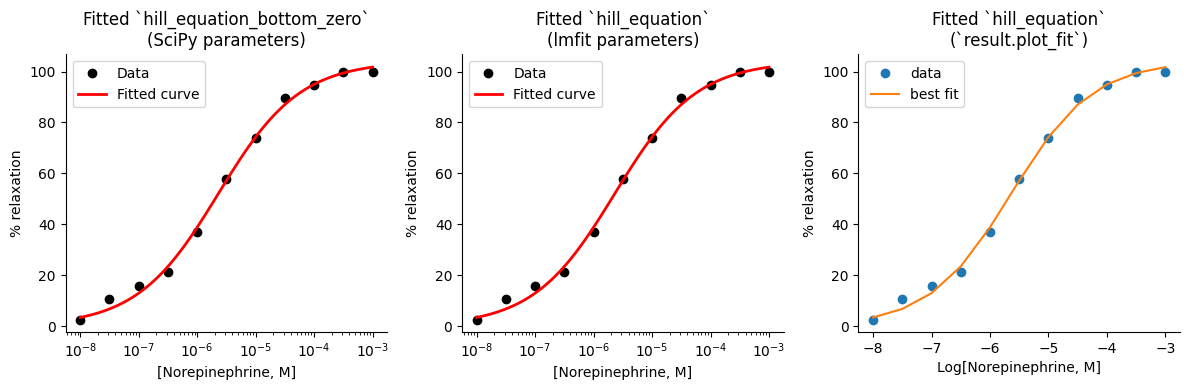

In [146]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Generate x-values for the curve in the range of norepi_log (log scale)
x_range = np.linspace(norepi_log.min(), norepi_log.max(), 100)

# Plot 1: Fitted `hill_equation_bottom_zero` (SciPy parameters)
# Calculate predicted values using the unpack (*) best-fit parameters array
predicted_values = hill_equation_bottom_zero(x_range, *best_vals)

axes[0].plot(norepi_lin, relaxation, 'ko', label="Data")  # Plot the data
axes[0].plot(10**x_range, predicted_values, 'r-', lw=2, label="Fitted curve")  # Plot the fitted curve
axes[0].set_xscale('log')
axes[0].set_xlabel("[Norepinephrine, M]")
axes[0].set_ylabel(r"% relaxation")
axes[0].set_title("Fitted `hill_equation_bottom_zero`\n(SciPy parameters)")
axes[0].legend()

# Plot 2: Fitted `hill_equation` (lmfit parameters)
# Calculate predicted values using the unpack (**) best-fit parameters dictionnary
predicted_values = hill_equation(x_range, **result.params)

# Plot the fitted curve and the data
axes[1].plot(norepi_lin, relaxation, 'ko', label="Data")  # Plot the data
axes[1].plot(10**x_range, predicted_values, 'r-', lw=2, label="Fitted curve")  # Plot the fitted curve
axes[1].set_xscale('log')
axes[1].set_xlabel("[Norepinephrine, M]")
axes[1].set_ylabel(r"% relaxation")
axes[1].set_title("Fitted `hill_equation`\n(lmfit parameters)")
axes[1].legend()

# Plot 3: Fitted `hill_equation`\n(`result.plot_fit`)
result.plot_fit(
    # datafmt='ko',
    xlabel="Log[Norepinephrine, M]",
    ylabel=r"% relaxation",
    title="Fitted `hill_equation`\n(`result.plot_fit`)",
    ax=axes[2])
# axes[2].set_xlabel("Log[Norepinephrine, M]")
# axes[2].set_ylabel("% relaxation")
# axes[2].set_title("Fitted `hill_equation`\n(`result.plot_fit`)")

sns.despine()
plt.tight_layout();

Note that `lmfit` provides a convenient way to get a quick overview of the fit, including both the fitted curve and the residuals, using the `result.plot()` function.

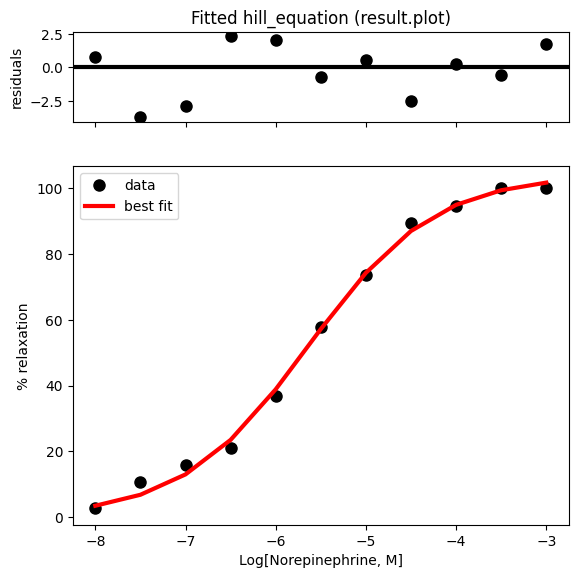

In [147]:
result.plot(
    datafmt='ko',
    fitfmt='r-',
    xlabel="Log[Norepinephrine, M]",
    ylabel=r"% relaxation",
    title="Fitted hill_equation (result.plot)",
    data_kws={'ms': 8},
    fit_kws={'lw': 3},
);

### Generating confidence intervals

In addition to visualizing the best-fit curve, it's often helpful to generate **confidence intervals** for the curve. These intervals provide a visual representation of the uncertainty in our model's predictions. They show us the range of plausible values for the response variable at different values of the independent variable.

As we discussed earlier, `lmfit` provides the standard errors of the estimated parameters. We can use these standard errors, along with the best-fit values, to construct **asymptotic confidence intervals** for the fitted curve. The general formula for calculating confidence intervals is:

$$\hat \theta \pm t \times s_{\hat \theta}$$

where:

- $\hat \theta$ is the best-fit value for the parameter
- $s_{\hat \theta}$ is the standard error of the parameter
- $t$ is the critical value from the t-distribution for the desired level of confidence (e.g., 95%) and the number of degrees of freedom (which equals the number of data points minus the number of parameters fit by the regression).

In [148]:
from scipy.stats import t as t_dist

# Calculate degrees of freedom
df = len(norepi_log) - len(best_vals)

# Calculate the critical t-value for a 95% confidence interval
t_critical = t_dist.ppf((1 + 0.95) / 2, df)

# Function to calculate confidence intervals
def get_ci(estimate, se):
    return (estimate - t_critical * se, estimate + t_critical * se)

# Print the 95% confidence intervals of the parameters
print("95% CI of parameters:")
print("---------------------")
print(f"df = {df}")
for i, param_name in enumerate(['Top', 'LogEC50', 'HillSlope']):
    ci_low, ci_high = get_ci(best_vals[i], standard_errors[i])
    print(f"{param_name} = {ci_low:.2f} to {ci_high:.2f}")

    # Special case for EC50 (convert to linear scale)
    if param_name == 'LogEC50':
        print(f"EC50 = {10**ci_low:.2e} to {10**ci_high:.2e}")

95% CI of parameters:
---------------------
df = 8
Top = 99.30 to 108.80
LogEC50 = -5.76 to -5.52
EC50 = 1.75e-06 to 3.02e-06
HillSlope = 0.54 to 0.70


Additionally, the `result.ci_report()` method can be used to generate a report that explicitly shows the confidence intervals for each parameter. We can also mention the optional arguments `with_offset, `ndigits`, and `sigmas` that allow to customize the desired confidence levelt and format of the report.

In [149]:
# Print the confidence interval report
print(result.ci_report(with_offset=False, ndigits=3, sigmas=[0.95]))

             95.00%  _BEST_  95.00%
 top       :  99.660 104.053 109.115
 logEC50   :  -5.749  -5.638  -5.516
 hill_slope:   0.544   0.622   0.713


Notice that the confidence intervals reported by `lmfit` are slightly different from the ones we calculated manually using the t-distribution, i.e., the asymptotic confidence intervals. This is because `lmfit` uses [**profile likelihood confidence intervals**](https://lmfit.github.io/lmfit-py/confidence.html), a more sophisticated method that takes into account the nonlinearity of the model and the correlations between the parameters. This generally provides more accurate and realistic confidence intervals, especially for nonlinear models.

However, directly applying this formula to the parameters and then generating the curve with the lower and upper confidence values of each parameter might not accurately reflect the uncertainty in the fitted curve, especially for nonlinear models. This is because:

- *Nonlinear relationships*: in nonlinear models, the relationship between the parameters and the predicted values can be complex and non-intuitive.  Changing one parameter might affect the curve in a way that's not simply captured by adding or subtracting a constant value.
- Parameter interdependence: the parameters in a nonlinear model are often interdependent. This means that changing one parameter can affect the optimal values of other parameters. Simply applying the formula to each parameter independently doesn't account for these interdependencies.
- Asymmetric confidence intervals: in some cases, the confidence intervals around a parameter might be asymmetric, especially in nonlinear models. This means that the uncertainty might be greater in one direction than the other. Directly applying the formula assumes symmetric intervals, which might not be accurate.

A simplified approach to drawing a confidence band is to generate predictions using the `hill_equation_bottom_zero` function, varying only one parameter at a time between its lower and upper confidence limits while holding the other parameters at their best-fit values. We can repeat this process for each of the 'top', 'logEC50', and 'hill_slope' parameters (recall that the 'bottom' parameter is fixed at zero). However, this simplification doesn't account for the uncertainties and interdependencies of the parameters.

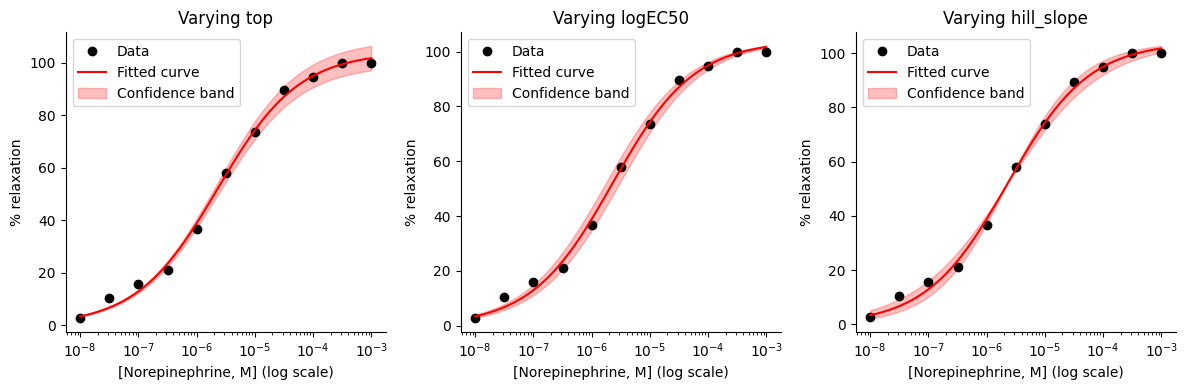

In [150]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Define a function to plot the confidence band for a given parameter
def plot_confidence_band(ax, param_name, param_index):
    # Calculate the lower and upper confidence bounds for the curve
    params_low = best_vals.copy()
    params_low[param_index] = best_vals[param_index] - t_critical * standard_errors[param_index]
    lower_bound = hill_equation_bottom_zero(x_range, *params_low)

    params_high = best_vals.copy()
    params_high[param_index] = best_vals[param_index] + t_critical * standard_errors[param_index]
    upper_bound = hill_equation_bottom_zero(x_range, *params_high)

    # Plot the fitted curve, confidence band, and the data
    ax.plot(norepi_lin, relaxation, 'ko', label="Data")
    ax.plot(10**x_range, predicted_values, 'r-', label="Fitted curve")
    ax.fill_between(
        10**x_range,
        lower_bound,
        upper_bound,
        color='red',
        alpha=.25,
        label="Confidence band")
    ax.set_xscale('log')
    ax.set_xlabel("[Norepinephrine, M] (log scale)")
    ax.set_ylabel(r"% relaxation")
    ax.set_title(f"Varying {param_name}")
    ax.legend()

# Plot the confidence bands for each parameter
plot_confidence_band(axes[0], 'top', 0)
plot_confidence_band(axes[1], 'logEC50', 1)
plot_confidence_band(axes[2], 'hill_slope', 2)

sns.despine()
plt.tight_layout();

Instead of directly applying the confidence interval formula to individual parameters, `lmfit` offers a more *robust approach* for generating confidence intervals that accurately reflect the uncertainty in the fitted curve. This is achieved using the `eval_uncertainty()` method.

The `eval_uncertainty()` method calculates the uncertainty in the predicted values at each point along the curve, taking into account the *full covariance matrix* and the model's nonlinearity. It applies error propagation techniques to estimate how the uncertainties in the parameters propagate through the nonlinear model function to affect the predicted values.

We can easily change the `sigma` value to visualize confidence bands corresponding to different confidence levels. For example, `sigma=1` corresponds to a 68% confidence interval (1 standard deviationn, approximately), while `sigma=1.96` corresponds to a 95% confidence interval.

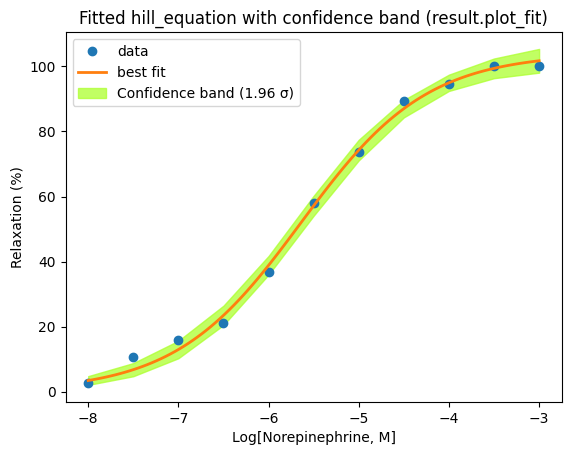

In [151]:
# Calculate the uncertainty in the predicted values
dely = result.eval_uncertainty(sigma=1.96) # type: ignore

# Plot the fitted curve, confidence band, and the data
result.plot_fit(
    # datafmt='ko',
    numpoints=100,
    fit_kws={'lw': 2},
)
plt.fill_between(
    norepi_log,
    result.best_fit - dely,
    result.best_fit + dely,
    color='greenyellow',
    alpha=.75,
    label="Confidence band (1.96 σ)")
plt.xlabel('Log[Norepinephrine, M]')
plt.ylabel('Relaxation (%)')
plt.title("Fitted hill_equation with confidence band (result.plot_fit)")
plt.legend()
plt.show()

### Exploring the parameter space visually

While the previous plots have shown us the overall fit of the model and its uncertainty, we can gain a deeper understanding by visually exploring the **parameter space**. This means visualizing how changes in the parameter values affect the shape and position of the fitted curve.

To explore the parameter space, we create plots where we vary one parameter at a time while holding the others constant. This will allow us to see how each parameter influences the curve and gain a more intuitive understanding of their roles in the model.

For example, we can plot the following curves on the same figure:

- *Initial guess*: the curve generated using the initial parameter guesses we provided to `lmfit`
- *Optimized parameters*: the curve generated using the optimized parameter values obtained from the fit
- *Modified parameters*: a curve generated with a specific parameter modified from its optimal value, e.g., a lower 'logEC50' or *an one unit Hill slope* (3PL equation), while keeping the other parameters at their optimal values. This allows us to isolate the effect of changing that specific parameter

This visualization will help us see how the initial guess compares to the optimal fit and how individual parameters influence the shape and position of the curve.

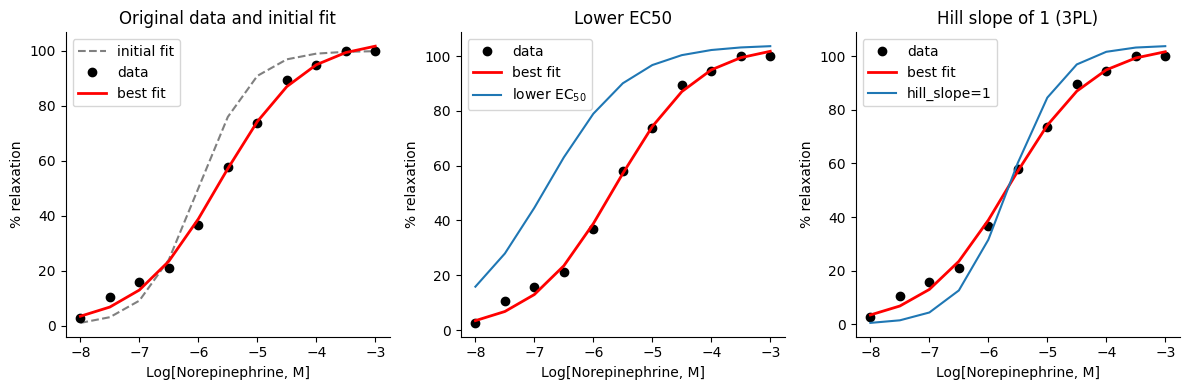

In [152]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot 1: Original data and initial guess
result.plot_fit(
    ax=axes[0],  # Plot on the first subplot
    datafmt='ko',
    fitfmt='r-',
    xlabel="Log[Norepinephrine, M]",
    ylabel=r"% relaxation",
    show_init=True,
    fit_kws={'lw': 2},
    init_kws={'c': 'grey'})
axes[0].set_title("Original data and initial fit")

# Plot 2: Lower EC50
result.plot_fit(
    ax=axes[1],  # Plot on the second subplot
    datafmt='ko',
    fitfmt='r-',
    xlabel="Log[Norepinephrine, M]",
    ylabel=r"% relaxation",
    show_init=False,  # Don't show the initial fit
    fit_kws={'lw': 2})
axes[1].plot(
    norepi_log,
    result.eval(
        top=result.params['top'].value,
        logEC50=-6.8,
        hill_slope=result.params['hill_slope'].value),
    label=r'lower $\rm EC_{50}$')
axes[1].legend()
axes[1].set_title("Lower EC50")

# Plot 3: Hill slope = 1
result.plot_fit(
    ax=axes[2],  # Plot on the third subplot
    datafmt='ko',
    fitfmt='r-',
    xlabel="Log[Norepinephrine, M]",
    ylabel=r"% relaxation",
    show_init=False,  # Don't show the initial fit
    fit_kws={'lw': 2})
axes[2].plot(
    norepi_log,
    result.eval(
        top=result.params['top'].value,
        logEC50=result.params['logEC50'].value,
        hill_slope=1),  # It's finally a 3PL equation
    label='hill_slope=1')
axes[2].legend()
axes[2].set_title("Hill slope of 1 (3PL)")

sns.despine()
plt.tight_layout();

The `results.eval` method is used to evaluate the model function with a specific set of parameter values. It takes the parameter names as keyword arguments and returns the predicted values of the dependent variable.

In essence, this code snippet generates predicted values for the Hill equation with a modified 'logEC50' or 'hill_slope' values while keeping the other parameters at their optimal values. This allows to see how changing the parameters affects the shape and position of the curve, providing insights into its role in the model.

This technique is valuable for exploring the parameter space and understanding the sensitivity of the model to changes in individual parameters. It helps visualize the relationship between the parameters and the predicted values, aiding in the interpretation of the model's behavior.

## Comparing nonlinear models

In the previous section, we explored how to visualize and interpret individual nonlinear models. We saw how to plot the fitted curve, generate confidence intervals, and explore the parameter space to understand the model's behavior. But what if we have multiple candidate models that might describe our data? How do we choose the best one? This is where **comparing nonlinear models** becomes essential.

Just as we did in previous chapters with linear models and comparing models in general, we can compare nonlinear models using various statistical criteria. One common approach is to compare the **sum of squares error (SSE)** or the **chi-squared (χ<sup>2</sup>)** values for different models. A model with a lower SSE or χ<sup>2</sup> generally indicates a better fit, as it means the model's predictions are closer to the observed data.

However, simply comparing the SSE or χ<sup>2</sup> values isn't always sufficient, especially when comparing models with different numbers of parameters. A model with more parameters might have a lower SSE simply because it has more flexibility to fit the data, even if it doesn't truly represent the underlying relationship better.

Therefore, we need more sophisticated methods to compare nonlinear models that take into account both the goodness of fit and the model's complexity. In this section, we'll explore some of these methods, including the **extra sum-of-squares F test** and **information criteria** like AIC and BIC.

### Nested models

Before we delve into specific statistical tests for comparing models, let's revisit the concept of **nested models**. As we discussed in the previous chapter, two models are considered nested if one model (the **reduced model**) can be obtained from the other model (the **full model**) by imposing constraints on the parameters of the full model.

For example, in our muscle relaxation study, we could consider the following nested models:

- _Full model_: the 4-parameter logistic (4PL) model, represented by the `hill_equation` function.
- _Reduced model 1_: the 4PL model with the 'bottom' parameter fixed to 0, represented by the `hill_equation_bottom_zero` function.
- _Reduced model 2_: the 3-parameter logistic (3PL) model, where the Hill slope is fixed to 1, represented by the `hill_equation_3pl` function.
- _Reduced model 3_: the 3PL model with the 'bottom' parameter fixed to 0. This is a 2-parameter model.

The relationships between these models can be visualized as follows:

```text
Full Model (4PL)
   ├── Reduced Model 1 (4PL, bottom = 0)
   └── Reduced Model 2 (3PL, Hill slope = 1)
       └── Reduced Model 3 (3PL, bottom = 0, Hill slope = 1)
```

### The extra sum-of-squares F test

The **extra sum-of-squares F test** is a statistical test specifically designed to compare nested models. It assesses whether the additional parameters in the full model significantly improve the fit compared to the reduced model.

It compares the residual sum of squares (RSS) / sum of squared error (SSE) of the two models. It calculates an F-statistic based on the difference in SSE and the degrees of freedom of the two models. This F statistic is then compared to the F-distribution to determine the P value.

#### Fitting the models to compare

Let's now compare two versions of our Hill equation model we plotted just before, both with the 'bottom' parameter fixed to 0:

- Variable Hill slope: this is the model we fitted earlier using `lmfit`, where all three parameters ('top', 'logEC50', and 'hill_slope') were allowed to vary.
- Fixed Hill slope (3PL model): this model has the Hill slope fixed to 1, effectively reducing it to a 3-parameter logistic (3PL) model. We will create another function called `hill_equation_3pl_bottom_zero`.

To compare the models with variable and fixed Hill slopes, we first define separate `Model` objects for each case. This allows us to clearly distinguish between the models and avoid the need for manually fixing parameters using `result.eval()`.

In [153]:
def hill_equation_3pl_bottom_zero(x, top, logEC50):
    """
    This function defines the 3-parameter logistic (3PL) equation with bottom fixed at 0.

    Args:
      x: The logarithm of norepinephrine concentration.
      top: The maximum relaxation (Ymax).
      logEC50: The logarithm of the EC50.

    Returns:
      The predicted relaxation values.
    """
    return top / (1 + 10**(logEC50 - x))  # hill_slope is fixed to 1

In [154]:
# Create a model object for the variable slope model
model_variable_slope = Model(hill_equation_bottom_zero)

# Create a model object for the fixed slope (3PL) model
model_fixed_slope = Model(hill_equation_3pl_bottom_zero)

# Initial guesses for the parameters
params_variable_slope = model_variable_slope.make_params(top=100, logEC50=-5, hill_slope=0.6)
params_fixed_slope = model_fixed_slope.make_params(top=100, logEC50=-5)

# Fit the models to the data
result_variable_slope = model_variable_slope.fit(data=relaxation, x=norepi_log, params=params_variable_slope)
result_fixed_slope = model_fixed_slope.fit(data=relaxation, x=norepi_log, params=params_fixed_slope)

# Print the reports
print(result_variable_slope.fit_report())
print('-'*40)
print(result_fixed_slope.fit_report())

[[Model]]
    Model(hill_equation_bottom_zero)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 11
    # variables        = 3
    chi-square         = 42.9570499
    reduced chi-square = 5.36963124
    Akaike info crit   = 20.9853605
    Bayesian info crit = 22.1790464
    R-squared          = 0.99712027
[[Variables]]
    top:         104.053046 +/- 2.05949490 (1.98%) (init = 100)
    logEC50:    -5.63808968 +/- 0.05151660 (0.91%) (init = -5)
    hill_slope:  0.62209903 +/- 0.03579791 (5.75%) (init = 0.6)
[[Correlations]] (unreported correlations are < 0.100)
    C(top, logEC50)        = +0.7796
    C(top, hill_slope)     = -0.6955
    C(logEC50, hill_slope) = -0.5410
----------------------------------------
[[Model]]
    Model(hill_equation_3pl_bottom_zero)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 11
    # variables        = 2
    chi-square         = 358.098998
    

#### Comparing the residuals

We can compare these models by examining their residual plots. This will help us visually assess whether fixing the Hill slope to 1 introduces any systematic patterns in the residuals, which might indicate a poorer fit compared to the more flexible variable slope model. We can already see from the `lmfit` reports that fixing the Hill slope to 1 indeed significantly increases the χ², suggesting that the variable slope model provides a better fit to the data.

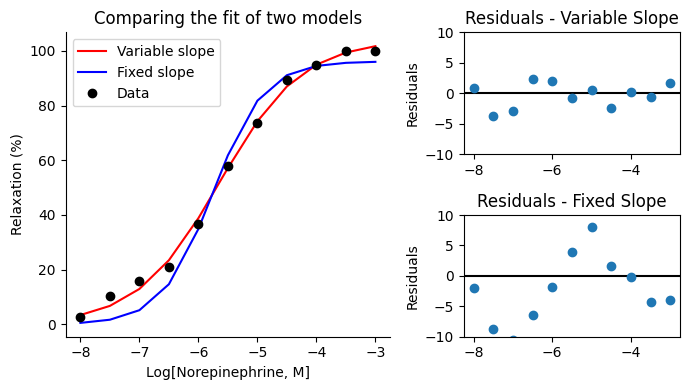

In [155]:
from matplotlib import gridspec

# Create a GridSpec object to define the layout
gs = gridspec.GridSpec(2, 2, width_ratios=[3,2])

# Create the axes using the GridSpec
fig = plt.figure(figsize=(7, 4))
ax_main = fig.add_subplot(gs[:, 0])  # Main plot spans both rows in the first column
ax_resid_var = fig.add_subplot(gs[0, 1])  # Variable slope residuals in the top-right
ax_resid_fix = fig.add_subplot(gs[1, 1])  # Fixed slope residuals in the bottom-right

# Plot the curves and data on the main axes
ax_main.plot(norepi_log, result_variable_slope.best_fit, 'r-', label='Variable slope')
ax_main.plot(norepi_log, result_fixed_slope.best_fit, 'b-', label='Fixed slope')
ax_main.plot(norepi_log, relaxation, 'ko', label='Data')
ax_main.set_title("Comparing the fit of two models")
ax_main.set_xlabel("Log[Norepinephrine, M]")
ax_main.set_ylabel(r"Relaxation (%)")
ax_main.legend()
sns.despine(ax=ax_main)

# Plot the residuals on their respective axes
result_variable_slope.plot_residuals(ax=ax_resid_var)
ax_resid_var.set_ylabel("Residuals")
ax_resid_var.set_ylim((-10, 10))
ax_resid_var.set_title("Residuals - Variable Slope")

result_fixed_slope.plot_residuals(ax=ax_resid_fix)
ax_resid_fix.set_ylabel("Residuals")
ax_resid_fix.set_ylim((-10, 10))
ax_resid_fix.set_title("Residuals - Fixed Slope")

plt.tight_layout();

The residual plot for the fixed slope model shows a clear wave pattern, indicating that the model's predictions systematically deviate from the observed data. This suggests that fixing the Hill slope to 1 introduces a bias, and the model is not flexible enough to capture the true relationship between norepinephrine concentration and muscle relaxation. In contrast, the residual plot for the variable slope model shows no obvious patterns, indicating a better fit to the data.

This observation, combined with the increase in χ² we saw earlier, provides strong evidence that the variable slope model is more appropriate for describing this dataset. It highlights the importance of allowing the Hill slope to vary to capture the nuances of the relationship between the variables.

#### Analysis of variance

Recall from the previous chapter that **analysis of variance (ANOVA)** provides a statistical framework for partitioning the total variation in a dataset into different sources. We can apply this framework to compare nested models by examining how much variation is explained by the additional parameters in the full model compared to the reduced model. To construct the ANOVA table, we extract the sum of squares (χ²) and degrees of freedom from the results of each model fit.

In [156]:
print("Model Comparison:")
print("----------------")
print(f"{'Model':<15} {'Sum of squares':>15} {'DF':>5}")
print(f"{'Fixed slope':<15} {result_fixed_slope.chisqr:15.1f} {result_fixed_slope.nfree:5d}")
print(f"{'Variable slope':<15} {result_variable_slope.chisqr:15.1f} {result_variable_slope.nfree:5d}")

Model Comparison:
----------------
Model            Sum of squares    DF
Fixed slope               358.1     9
Variable slope             43.0     8


The *null hypothesis* in the extra sum-of-squares F test is indeed that the simpler model (with fewer parameters) is adequate. In our case, the simpler model is the one with the fixed Hill slope (3PL model), which has one fewer parameter than the variable slope model (4PL model), since in both models 'bottom' was fixed to zero.

Remember that the **degrees of freedom (DF)** represent the number of independent pieces of information available to estimate a particular source of variation. In our case, the degrees of freedom are calculated as follows:
- Null hypothesis (fixed slope model): this is equal to the number of data points (11 in our example) minus the number of parameters in the fixed slope model (2: 'top' and 'logEC50'). So, $\rm DF = 11 - 2 = 9$.
- Alternative hypothesis (variable slope model): this is equal to the number of data points minus the number of parameters in the variable slope model (3: 'top', 'logEC50', and 'hill_slope'). So, $\rm DF = 11 - 3 = 8$.
- Difference (improvement): this is the difference in degrees of freedom between the two models, which represents the number of additional parameters in the variable slope model compared to the fixed slope model. So, $\rm DF = 9 - 8 = 1$.

We can summarize the sources of variation from the models and the resulting improvement as follows:

| Hypothesis  | Model                | χ²    | DF |
|:----------- |:-------------------- |:----- |:-- |
| Null        | Fixed slope (3PL)    | 358.1 | 9  |
| Alternative | Variable slope (4PL) | 43.0  | 8  |
| Difference  | Improvement          | 315.1 | 1  |

#### Mean squares

In the ANOVA table, we also calculate **mean squares (MS)**, which represent the average variation attributed to each source, adjusted for their degrees of freedom. They allow us to compare different sources of variation on a more even playing field.

To calculate the mean square for the *difference between the models* (MSR), we divide the sum of squares for the difference (SSR) by its degrees of freedom:

$$\rm MSR = SSR / DF$$

We can also calculate the mean squared error (MSE) for each model individually. This represents the average variability of the residuals for that specific model. The general formula for MSE is:

$$\text{MSE} = \text{SSE} / (n - p - 1)$$

where $\rm SSE$ is the sum of squared errors (residuals) for the model, $n$ is the number of data points, and $p$ is the number of parameters in the model.

The MSE of the variable slope model represents the variance that remains unexplained after accounting for the additional flexibility of the variable slope. In other words, it's the variance that the simpler model (fixed slope) would also have to deal with.

In [157]:
# Calculate and print the mean squares
print("\nMean squares:")
print("------------")

# Mean square for the fixed slope model (MSE_fixed)
mse_fixed = result_fixed_slope.chisqr / result_fixed_slope.nfree # type: ignore
print(f"MSE (fixed slope): {mse_fixed:.2f}")

# Mean square for the variable slope model (MSE_variable)
mse_variable = result_variable_slope.chisqr / result_variable_slope.nfree # type: ignore
print(f"MSE (variable slope): {mse_variable:.2f}")

# Mean square for the difference between the models (MSR)
ms_diff = (
    (result_fixed_slope.chisqr - result_variable_slope.chisqr) # type: ignore
    /
    (result_fixed_slope.nfree - result_variable_slope.nfree) # type: ignore
)
print(f"MSR (difference): {ms_diff:.2f}")


Mean squares:
------------
MSE (fixed slope): 39.79
MSE (variable slope): 5.37
MSR (difference): 315.14


#### F-ratio

However, it's important to note that the MSE calculated in this way is not directly used in the F-test for comparing the models.

The F-test is designed to assess whether the additional complexity of the full model (variable slope) leads to a significant improvement in the fit compared to the reduced model (fixed slope). The term "extra sum of squares" comes from the idea that we're examining the* extra amount of variation* in the dependent variable that is explained by adding *extra terms or parameters* to a model. 

The F-ratio is essentially a ratio of the variance explained by the extra parameter(s) in the full model (MSR) to the variance that remains unexplained even by the full model (MSE of the variable slope model).

In [158]:
# Calculate the F-ratio
n = len(relaxation)  # Number of observations
df_numerator = result_fixed_slope.nfree - result_variable_slope.nfree  # DF for the difference between models (1 in this case)
df_denominator = result_variable_slope.nfree  # DF for the variable slope model (the more complex model)
f_value = (
    ((result_fixed_slope.chisqr - result_variable_slope.chisqr) / df_numerator) # type: ignore
    /
    (result_variable_slope.chisqr / df_denominator) # type: ignore
)
print(f"F ratio = {f_value:.3f}")

F ratio = 58.690


#### P value

To calculate the P value, we use the `scipy.stats.f` module in Python, which provides functions for working with the F-distribution. Specifically, we use the `sf()` function (survival function) which tells us the probability of observing an F-ratio as extreme as, or more extreme than, the one we calculated, if the null hypothesis were true. This probability is our P value.

In [159]:
from scipy.stats import f

# Calculate the P value using the survival function (sf) of the F-distribution
p_value = f.sf(f_value, dfn=df_numerator, dfd=df_denominator)  # Use df_numerator and df_denominator

print(f"P-value = {p_value:.5f}")

P-value = 0.00006


In our example comparing the fixed slope and variable slope models, with an F-ratio of 58.690 and degrees of freedom of 1 and 8, the P-value is < 0.0001. This means that if the simpler fixed slope model were truly adequate, there would be less than 0.01% chance of observing an F-ratio this large or larger due to random sampling. This extremely small P value provides overwhelming evidence against the null hypothesis. We can therefore conclude that the variable slope model provides a significantly better fit to the data than the fixed slope model.

#### Visualizing the F-distribution and critical values

To visualize how the P value and critical value are determined, we can consider the F-distribution. This distribution represents the probability of observing different F-ratios under the null hypothesis. The critical value is the F-value that corresponds to our chosen significance level (α). If our calculated F-ratio exceeds this critical value, it falls within the rejection region, leading us to reject the null hypothesis.

The P value represents the probability of observing an F-ratio as extreme as, or more extreme than, the one we calculated, assuming the null hypothesis is true. It's represented by the area under the F-distribution curve to the right of our calculated F-ratio.

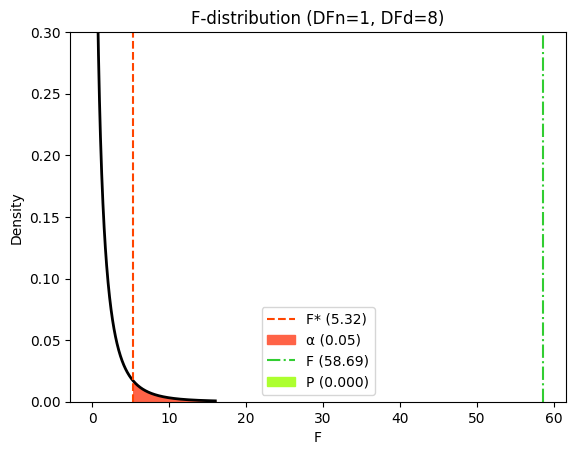

In [160]:
# Significance level (alpha)
α = 0.05

# Calculate critical F-value
f_crit = f(dfn=df_numerator, dfd=df_denominator).ppf(1 - α)

# Generate x values for plotting
x_f = np.linspace(0, 16, 500)
hx_f = f.pdf(x_f, df_numerator, df_denominator)

# Create the plot
plt.plot(x_f, hx_f, lw=2, color='black')

# Critical value
plt.axvline(
    x=f_crit,
    color='orangered',
    linestyle='--',
    label=f"F* ({f_crit:.2f})")

# Alpha area
plt.fill_between(
    x_f[x_f >= f_crit],
    hx_f[x_f >= f_crit],
    color='tomato',
    label=f"α ({α})")

# F-statistic
plt.axvline(
    x=f_value,
    color='limegreen',
    linestyle='-.',
    label=f"F ({f_value:.2f})")

# P-value area
plt.fill_between(
    x_f[x_f >= f_value],
    hx_f[x_f >= f_value],
    color='greenyellow',
    label=f"P ({p_value:.3f})")

plt.xlabel("F")
plt.ylabel('Density')
plt.ylim(0, .3)
plt.title(f"F-distribution (DFn={df_numerator}, DFd={df_denominator})")
plt.margins(x=0.05, y=0)
plt.legend();

In our example comparing the fixed slope and variable slope models, the calculated F-ratio of 58.690 falls far to the right of the critical value, and the corresponding area under the curve (P value) is extremely small (<0.0001). This visually confirms the strong evidence against the null hypothesis, supporting our conclusion that the variable slope model provides a significantly better fit to the data than the fixed slope model.

#### ANOVA table

As we've seen, the key components of ANOVA, i.e., sums of squares, degrees of freedom, and mean squares, provide a framework for comparing models and assessing their fit. We can construct an ANOVA table to summarize these components and formally test the significance of the difference between our fixed slope and variable slope models.

| Source of variation | Sum of squares | DF | MS     | F ratio | P value |
|---------------------|----------------|----|--------|---------|---------|
| Difference          | 315.1          | 1  | 315.14 | 58.69   | <0.0001 |
| Variable slope      | 43.0           | 8  | 5.37   |         |         |
| Fixed slope         | 358.1          | 9  |        |         |         |

The null hypothesis in this comparison is that the **fixed slope model is adequate**, meaning that fixing the Hill slope to 1 does not significantly reduce the model's ability to fit the data. In other words, the null hypothesis states that the additional flexibility of the variable slope in the 4PL model does not provide a significant improvement in the fit.

If the null hypothesis were true, we would expect the extra sum of squares due to the variable slope to be small, and the corresponding MSR would be similar to the MSE of the variable slope model. This would result in an F-ratio close to 1.0.

The variable slope model does provide a significantly better fit, resulting in a larger extra sum of squares, a larger MSR, and ultimately a larger F-ratio. This large F-ratio indicates that the improvement in fit due to the variable slope is greater than the variability that remains unexplained even by the more complex model.

### Model selection criteria: AIC and BIC

While the extra sum-of-squares F test is useful for comparing nested models, we often encounter situations where we need to compare models that are not nested. In such cases, we can use **information criteria** like the **Akaike Information Criterion (AIC)** and the **Bayesian Information Criterion (BIC)**.

AIC and BIC are statistical measures that estimate the prediction error for a statistical model relative to other statistical models trained on the same data. They are calculated based on the model's likelihood (a measure of how well the model fits the data) and the number of parameters in the model:

- AIC is calculated as: $\text{AIC} = 2 k - 2 \log(L)$, where $k$ is the number of parameters and $L$ is the maximum likelihood estimator (MLE), discussed briefly at the end of the chapter on simple linear regression.
- BIC is calculated as: $\text{BIC} = k \log(n) - 2 \log(L)$, where $n$ is the number of data points.

BIC penalizes models with more parameters more heavily than AIC, especially for larger sample sizes. This means that BIC tends to favor simpler models compared to AIC. On the other side, AIC is asymptotically equivalent to leave-one-out cross-validation, while BIC is consistent for model selection under certain assumptions.

The choice between AIC and BIC depends on the specific goals and preferences. If the primary goal is prediction accuracy, AIC might be preferred. If the goal is to identify the true underlying model, BIC might be more suitable.

`lmfit` conveniently provides the AIC and BIC values in the fit report (`result.fit_report()`). We can also access them directly using the `result.aic` and `result.bic` attributes. We can use these values to compare different nonlinear models fit to the same data.

In [161]:
# Print the AIC and BIC values for the variable slope model
print("\nVariable slope model:")
print(f"AIC: {result_variable_slope.aic:.2f}") # type: ignore
print(f"BIC: {result_variable_slope.bic:.2f}") # type: ignore

# Print the AIC and BIC values for the fixed slope model
print("\nFixed slope model:")
print(f"AIC: {result_fixed_slope.aic:.2f}") # type: ignore
print(f"BIC: {result_fixed_slope.bic:.2f}") # type: ignore


Variable slope model:
AIC: 20.99
BIC: 22.18

Fixed slope model:
AIC: 42.31
BIC: 43.11


*Lower values* of AIC and BIC indicate a *better model*. When comparing models, the model with the lowest AIC or BIC is generally preferred.

In our example, both AIC (20.99) and BIC (22.18) are lower for the variable slope model compared to the fixed slope model (AIC: 42.31, BIC: 43.11). This indicates that the variable slope model is preferred according to both criteria. It suggests that the improved fit achieved by allowing the Hill slope to vary outweighs the penalty for the additional parameter.

This conclusion reinforces the results of the extra sum-of-squares F test and the visual analysis of the residuals, providing further support for choosing the variable slope model as the better representation of the data.

However, it's important to be aware of the potential for **overfitting**, especially when dealing with complex models. This is a particular concern in the field of **machine learning**, where models can have a large number of parameters and complex architectures.

Overfitting occurs when a model is too complex and learns the training data too well, including its noise and random fluctuations. This can lead to a model that performs well on the training data but poorly on new, unseen data.

**Model complexity** refers to the number of parameters and the flexibility of a model. More complex models have more parameters and can fit a wider range of data patterns. However, this increased flexibility can also make them more prone to overfitting, leading to:

- Poor generalization: the model might not generalize well to new data, leading to inaccurate predictions.
- Misleading interpretations: the model might capture spurious relationships in the data, leading to incorrect conclusions about the underlying biological processes.
- Unstable parameter estimates: the estimated parameters might be highly sensitive to small changes in the data, making them unreliable.

There are several techniques to address overfitting, including:

- Using simpler models: choosing a simpler model with fewer parameters can reduce the risk of overfitting.
- Regularization: adding penalty terms to the objective function can discourage the model from fitting the noise in the data.
- Cross-validation: evaluating the model on different subsets of the data can help assess its generalization performance.
- Bootstrapping: as we'll see in the next section, bootstrapping can help us assess the stability and variability of our parameter estimates and predictions, providing insights into the potential for overfitting.

## Bootstrapping for nonlinear regression

Bootstrapping is a resampling method that allows us to estimate the uncertainty in our parameter estimates and predictions without making strong assumptions about the underlying distribution of the data. It's particularly useful in situations where the data might not meet the assumptions of traditional statistical methods (e.g., normality of errors), we want to estimate the variability of our estimates or predictions, or we want to assess the stability and robustness of our model.

In this section, we'll explore how to apply bootstrapping to nonlinear regression. We'll see how it can help us:

- Estimate the uncertainty in our parameter estimates.
- Generate confidence intervals for parameters and predictions.
- Assess the stability of our model and its sensitivity to the data.

### Bootstrapping in non-linear regression

As we've seen in previous chapters, **bootstrapping** is a powerful resampling technique that allows us to estimate the uncertainty in our statistical estimates. We've used it to construct confidence intervals for the mean, compare groups using t-tests, assess the strength of correlations, and even analyze the uncertainty in linear regression coefficients. 

The good news is that this versatile technique can also be applied to nonlinear regression models! 

Recall that the basic idea of bootstrapping is to create many new datasets by *randomly sampling with replacement* from our original dataset. We then fit our model to each of these bootstrap samples and obtain a distribution of parameter estimates. This distribution reflects the variability in our estimates due to the random sampling inherent in our original data.

By analyzing this distribution we can calculate the standard deviation of the bootstrap parameter estimates, which provides an estimate of the standard error of each parameter. We can also use the percentiles of the bootstrap distribution to construct confidence intervals for the parameters, and examine the shape of the bootstrap distribution to assess the **stability** of our parameter estimates and identify any potential biases.

While the general principles of bootstrapping remain the same, there are a few key differences and considerations when applying it to nonlinear regression:

- Model complexity: non-linear models can be more complex than linear models, with more parameters and potentially nonlinear relationships between the variables. This can affect the *convergence* and stability of the model fitting process during bootstrapping.
- Computational cost: bootstrapping involves fitting the model many times (e.g., 1000 or more), which can be computationally expensive for complex nonlinear models.
- Initial guesses: providing good initial guesses for the parameters becomes even more important in bootstrapping, as it can help ensure that the model converges to a reasonable solution for each bootstrap sample.

#### Generating bootstrap samples

Just as we did for correlation analysis and linear regression, the core idea of bootstrapping in nonlinear regression is to treat our observed sample of data points as a representation of the population. We then resample these data points with replacement to create many new bootstrap samples.

For each bootstrap sample, we fit our nonlinear regression model and obtain the estimated parameters. This process generates a collection of bootstrap estimates that we can use for inference:

1. Resample the data: randomly sample the data points (pairs of independent and dependent variable values) with replacement to create a bootstrap sample. The bootstrap sample should have the same size as the original dataset.
2. Fit the model: fit the nonlinear regression model to the bootstrap sample and obtain the estimated parameters.
3. Repeat: repeat steps 1 and 2 many times (e.g., 1000 or more) to create a collection of bootstrap estimates for the parameters.
4. Analyze the bootstrap distribution: use the distribution of the bootstrap estimates to calculate confidence intervals, standard errors, or other inferential statistics.

In [175]:
def draw_bs_pairs_nonlinreg(x, y, model_function, initial_params, size=1):
    """Perform pairs bootstrap for nonlinear regression and return parameters."""

    inds = np.arange(len(x))
    bs_params_reps = np.empty((size, len(initial_params)))  # Array to store bootstrap parameter estimates

    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds), replace=True)
        bs_x, bs_y = x[bs_inds], y[bs_inds]

        # Fit the nonlinear regression model with `curve_fit`
        try:
            best_vals, _ = curve_fit(model_function, bs_x, bs_y, p0=initial_params)
        except RuntimeError as e:
            # Handle cases where the fit might not converge
            print(f"Warning: Fit did not converge for bootstrap sample {i + 1}: {e}")

        bs_params_reps[i, :] = best_vals

    return bs_params_reps

We've added a `try-except` block to handle cases where the fit might not converge for some bootstrap samples.

In [176]:
# Set random seed for reproducibility
np.random.seed(111)

# Set the number of bootstrap replicates
B = 10_000

# Generate bootstrap replicates of the parameters
bs_params_reps = draw_bs_pairs_nonlinreg(
    x=norepi_log,
    y=relaxation,
   model_function=hill_equation_bottom_zero,
   initial_params=p0,  # p0=[100, -6, 1], as in the previous sections
   size=B)

# Print the first 5 replicates for each parameter
print("top replicates:", bs_params_reps[:5, 0])
print("logEC50 replicates:", bs_params_reps[:5, 1])
print("hill_slope replicates:", bs_params_reps[:5, 2])

top replicates: [106.74351124 104.54797682 103.62662831 103.72617883 104.50075986]
logEC50 replicates: [-5.56677302 -5.68082929 -5.63270256 -5.64913139 -5.61797421]
hill_slope replicates: [0.60082667 0.58383754 0.63653616 0.60413869 0.63394325]


We might encounter "Warning: Fit did not converge for bootstrap sample xxxx" during the bootstrapping process. It indicates that the `curve_fit` function failed to converge to a solution for some of the bootstrap samples. This is not uncommon in nonlinear regression, and it often suggests that the model is complex or the data is noisy or limited.

We could try to improve the initial guesses for the parameters, increase the number of iterations within `curve_fit` using the 'maxfev' argument (which is 100*(N+1) by default), or try different fitting methods such as 'lm', 'trf', or 'dogbox'. However, a small number of non-converged samples, as in our case, is usually not a major concern, especially when we have a large number of bootstrap replicates.

#### Confidence intervals

Now that we have a collection of bootstrap replicates for our nonlinear model's parameters, we can use them to construct confidence intervals. These intervals provide a range of plausible values for the true population values of the parameters.

To estimate the confidence intervals, we'll use the percentiles of the bootstrap distributions. For example, to construct a 95% confidence interval for a parameter, we'll use the 2.5th and 97.5th percentiles of its bootstrap replicates. This means that 95% of the bootstrapped values for that parameter fall within this interval, providing a range of plausible values for the true population parameter.

In nonlinear models, the interpretation of the parameters might be more complex than in linear models. The confidence intervals provide a range of plausible values, but the biological interpretation of those values might require careful consideration of the nonlinear relationships involved.

In [178]:
# Print the maximal value of the 'top' parameter in the bootstrap replications
print(f"Maximal value of the top parameter in the bootstrap replicates: {np.max(bs_params_reps[:, 0]):.1f}")
# Use np.nanmax to ignore NaN values

Maximal value of the top parameter in the bootstrap replicates: 924.2


In our example, we encountered a bootstrap replicate where the 'top' parameter reached a value of 924.2%, which is clearly unrealistic for a maximum relaxation response that should be around 100%. This illustrates a potential limitation of bootstrapping in nonlinear regression: the iterative optimization process can sometimes lead to *extreme parameter values* for certain bootstrap samples, especially if the model is complex or the data is noisy.

However, we can implement safeguards within the bootstrapping process itself to mitigate this issue. For instance, we can add checks to identify and exclude replicates with unreasonable parameter values, and assign NaN values This helps ensure that the bootstrap distribution is not unduly influenced by these extreme cases.

It's important to be aware of these potential limitations and to carefully examine the bootstrap replicates to identify any unusual or unrealistic values. By implementing appropriate safeguards and refining the bootstrapping process, we can improve the reliability and accuracy of our uncertainty estimates.

In [179]:
# Set random seed for reproducibility
np.random.seed(111)

# Set the number of bootstrap replicates
B = 10_000

# Generate bootstrap replicates of the parameters
bs_params_reps = draw_bs_pairs_nonlinreg(
    x=norepi_log,
    y=relaxation,
   model_function=hill_equation_bottom_zero,
   initial_params=p0,  # p0=[100, -6, 1], as in the previous sections
   size=B)

# Check for unrealistic values and replace with NaN
for i, params in enumerate(bs_params_reps):
    if params[0] > 250 or np.abs(params[2]) > 10:  # Check 'top' and 'hill_slope'
        print(f"Warning: Unrealistic parameter values for bootstrap sample {i + 1}")
        bs_params_reps[i, :] = np.nan  # Assign NaN values for the entire row

# Print the number of NaN bootstrap replicates
print(f"Number of invalid bootstrap replicates: {np.sum(np.isnan(bs_params_reps))}")

Number of invalid bootstrap replicates: 21


In [180]:
# Calculate the means, SEs, and 95% confidence intervals for each parameter
bs_params_means = np.nanmean(bs_params_reps, axis=0)  # Use np.nanmean to ignore NaNs
bs_params_se = np.nanstd(bs_params_reps, axis=0, ddof=1)  # Use np.nanstd to ignore NaNs
bs_params_ci = np.nanpercentile(bs_params_reps, [2.5, 97.5], axis=0)  # Use np.nanpercentile to ignore NaNs

# Print the results
print("Bootstrap Statistics:")
print("---------------------")
for i, param_name in enumerate(['top', 'logEC50', 'hill_slope']):
    print(f"{param_name}:")
    print(f"  Mean = {bs_params_means[i]:.4f}")
    print(f"  SE = {bs_params_se[i]:.4f}")
    print(f"  95% CI = {bs_params_ci[:, i]}")

Bootstrap Statistics:
---------------------
top:
  Mean = 104.8493
  SE = 3.9434
  95% CI = [101.75121552 112.26225763]
logEC50:
  Mean = -5.6261
  SE = 0.0713
  95% CI = [-5.71889986 -5.46448744]
hill_slope:
  Mean = 0.6172
  SE = 0.0429
  95% CI = [0.53992946 0.70512507]


Interestingly, the bootstrap confidence interval for the 'top' parameter ([101.75, 112.26]) is wider and slightly higher than the parametric intervals calculated earlier, either manually ([99.3, 108.80]) or by `lmfit` ([99.660, 109.115]). This is likely related to the higher standard error estimated by the bootstrap method (3.9434) compared to the parametric approaches (2.06). This suggests greater uncertainty in estimating the maximum relaxation ('top') compared to the other parameters, possibly due to the 'top' parameter being more sensitive to variations in the data, especially at higher norepinephrine concentrations. The structure of the Hill equation itself might also contribute to this, as it could allow for more flexibility in the 'top' parameter compared to the others. Additionally, there might be interdependencies between the parameters, where the uncertainty in estimating 'logEC50' and 'hill_slope' indirectly influences the uncertainty in 'top'.

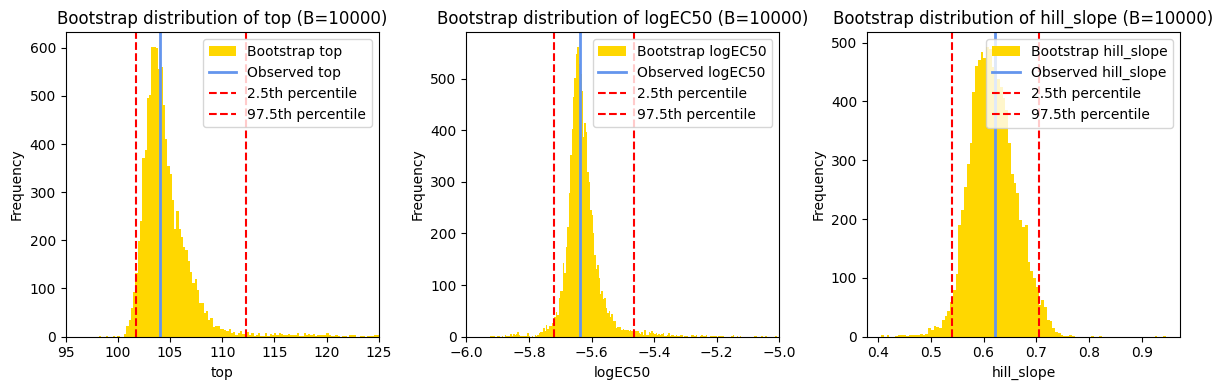

In [181]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot the bootstrap distributions for each parameter
for i, param_name in enumerate(['top', 'logEC50', 'hill_slope']):
    axes[i].hist(
        bs_params_reps[:, i],
        bins='auto',
        color='gold',
        label=f'Bootstrap {param_name}')
    axes[i].axvline(
        x=result.params[param_name].value,
        color='cornflowerblue',
        linestyle='-',
        lw=2,
        label=f'Observed {param_name}')
    axes[i].axvline(
        x=bs_params_ci[0, i],
        color='red',
        linestyle='--',
        label='2.5th percentile')
    axes[i].axvline(
        x=bs_params_ci[1, i],
        color='red',
        linestyle='--',
        label='97.5th percentile')
    # Adjust slightly the x-axis limits
    if param_name == 'top':
        axes[i].set_xlim((95, 125))
    elif param_name == 'logEC50':
        axes[i].set_xlim((-6, -5))

    axes[i].set_xlabel(param_name)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f"Bootstrap distribution of {param_name} (B={B})")
    axes[i].legend()

plt.tight_layout();

The bootstrap distribution for the 'top' parameter shows a clear skew towards higher values, while the distributions for the 'logEC50' and 'hill_slope' parameters appear more symmetric.But overall, the results from the bootstrapping approach are comparable to those obtained from the parametric methods, suggesting that both provide reasonable estimates of the uncertainty in our nonlinear model.

#### Confidence band

Earlier, we visualized the 95% confidence band around the fitted nonlinear curve. Now, let's explore how the curve itself varies across different bootstrap samples. This will provide a more intuitive understanding of the uncertainty captured by the confidence band.

The following plot shows several bootstrapped curves, each fitted to a different resampled dataset. The variability of these curves reflects the uncertainty in the estimated relationship between the variables. Notice how the spread of these curves relates to the width of the confidence band we visualized earlier.

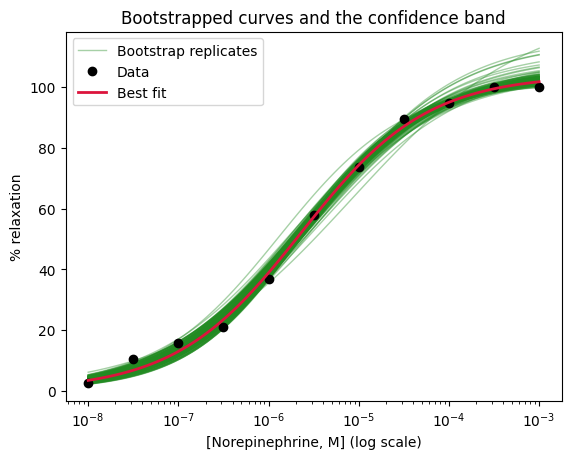

In [168]:
# Plot the variability of the fitted curves
for i in range(200):
    # Generate predicted values using bootstrap parameter replicates
    predicted_values = hill_equation_bottom_zero(x_range, *bs_params_reps[i, :])
    plt.plot(
        10**x_range,
        predicted_values,
        color='forestgreen',
        lw=1,
        alpha=.4,
        label='Bootstrap replicates' if i==0 else None)  # Print label only once in legend

# Plot the original data and the best-fit curve
plt.plot(norepi_lin, relaxation, 'ko', label='Data')
plt.plot(
    10**x_range,
    hill_equation_bottom_zero(x_range, *best_vals),
    color="crimson",
    lw=2,
    label='Best fit')

plt.xscale('log')
plt.xlabel("[Norepinephrine, M] (log scale)")
plt.ylabel("% relaxation")
plt.title("Bootstrapped curves and the confidence band")
plt.legend();

Looking at the plot, we can see that the bootstrapped curves exhibit more variability in the upper-right region, corresponding to the highest norepinephrine concentrations. Some of the curves even detach from the confidence band at the two highest x-values. This suggests that our model is less certain about the predictions in that region, possibly due to the limited data or the nature of the response plateauing at higher concentrations.

## Conclusion

In this chapter, we explored nonlinear regression, learning how to model complex relationships in biological data that cannot be captured by linear models. We started with the mathematical foundations, examining common nonlinear functions and the concept of least squares estimation.

We then dove into the practical application of nonlinear regression using Python. We learned how to fit models using `scipy.optimize.curve_fit` and the more advanced `lmfit` package. This included defining model functions, providing initial parameter guesses, and extracting the best-fit parameter estimates.

`lmfit` provided us with tools to impose constraints on parameters, ensuring biologically meaningful results. We also gained access to a wider range of fit statistics and diagnostics to assess the quality of our models.

Visualization played a crucial role in understanding and interpreting the results. We plotted fitted curves, generated confidence intervals, and explored the parameter space to see how changes in parameter values affect the model's predictions.

We discussed the importance of considering model complexity and the risk of overfitting, where a model captures noise rather than the true underlying relationship.

Finally, we applied bootstrapping to estimate the uncertainty in our parameter estimates and predictions. This non-parametric technique allowed us to assess the variability and stability of our models.

With this knowledge of nonlinear regression, we are now equipped to analyze more complex biological datasets and uncover hidden patterns that linear models cannot capture. In the next chapter, we'll expand our toolkit further by exploring multiple regression, where we'll incorporate multiple independent variables into our models. This will allow us to analyze even more intricate scenarios and gain a deeper understanding of the factors that influence biological processes.

## Cheat sheet

### Fitting a model

```python
# Defining the model function
def hill_equation(x, bottom, top, logEC50, hill_slope):
    return bottom + (top - bottom) / (1 + 10**((logEC50 - x) * hill_slope))

p0 = [a, b, c, d]  # Initial guess for the parameters

# Fit the model to the data with curve_fit
from scipy.optimize import curve_fit

popt, pcov = curve_fit(
    hill_equation,
    X,  # Array of the independent variable
    y,  # Array of the dependent variable
    p0=p0)

# Calculate the standard errors of the parameters
standard_errors = np.sqrt(np.diag(pcov))

# Fit the model using lmfit
from lmfit import Model
model = Model(hill_equation)
params = model.make_params()  # Initialize parameters object
params.add('a', value=a, min=0, vary=False)  # Add individual paramters and constraints

result = model.fit(data=y, x=X, params=params)  # Fit the model to the data
result.best_values  # Access the best-fit values
result.chisqr  # Access the sum of sqaures error (RSS)

# Print the full fit report
print(result.fit_report())

# Access and display the fit results using result.result
result.result

# Predictions
predicted_y = hill_equation(new_x, *popt)  # Best-fit values from SciPy
predicted_y = hill_equation(new_x, **result.params)  # From lmfit
predicted_y = result.eval(x=new_x)  # Using directly lmfit result
```

### Goodness of fit

```python
import matplotlib.pyplot as plt
# Plot residuals
result.plot_residuals()

result.rsquared  # R²
```

### Visualizing non-linear models

```python
# Plot the optimal curve
result.plot_fit()

# Plot the optimal curve and residuals
result.plot()

# Explore the parameter space
result.plot_fit()  # Data and best-fit
predicted_y = result.eval(a=a1, b=b1)
plt.plot(new_x, predicted_y)
```

### Confidence intervals

```python
# Print the confidence interval report
print(result.ci_report())  # See also with_offset and sigmas options

# Calculate the uncertainty in the predicted values
result.eval_uncertainty()
```

### Comparing non-linear models

```python
# Fit the two models to compare 
# model_1 = Model(equation_1)  # More complex of the two
# params_model_1 = model_1.make_params()
# result_model_1 = model_1.fit()
# model_2 = Model(equation_2)  # Nested model

# Calculate the F-ratio
n = len(y)  # Number of observations
df_numerator = result_model_2.nfree - result_model_1.nfree  # DF for the difference between models
df_denominator = result_model_1.nfree  # DF the more complex model
f_value = (
    ((result_model_2.chisqr - result_model_1.chisqr) / df_numerator)
    /
    (result_model_1.chisqr / df_denominator)
)

# Calculate the P value using the survival function of the F-distribution
from scipy.stats import f
p_value = f.sf(f_value, dfn=df_numerator, dfd=df_denominator)
```

### Bootstrapping

```python
def draw_bs_pairs_nonlinreg(x, y, model_function, initial_params, size=1):
    """Perform pairs bootstrap for nonlinear regression and return parameters."""

    inds = np.arange(len(x))
    bs_params_reps = np.empty((size, len(initial_params)))  # Array to store bootstrap parameter estimates

    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds), replace=True)
        bs_x, bs_y = x[bs_inds], y[bs_inds]

        # Fit the nonlinear regression model with `curve_fit`
        try:
            best_vals, _ = curve_fit(model_function, bs_x, bs_y, p0=initial_params)
        except RuntimeError as e:
            # Handle cases where the fit might not converge
            print(f"Warning: Fit did not converge for bootstrap sample {i + 1}: {e}")

        bs_params_reps[i, :] = best_vals

    return bs_params_reps

# Set the number of bootstrap replicates
B = 10_000

# Generate bootstrap replicates of the parameters
bs_params_reps = draw_bs_pairs_nonlinreg(
    x=X,
    y=y,
   model_function=hill_equation
   initial_params=p0,
   size=B)

# Check for unrealistic values and replace with NaN
for i, params in enumerate(bs_params_reps):
    if params[0] > 250 or np.abs(params[2]) > 10:  # Check 'top' and 'hill_slope'
        print(f"Warning: Unrealistic parameter values for bootstrap sample {i + 1}")
        bs_params_reps[i, :] = np.nan  # Assign NaN values for the entire row

# Calculate the means, SEs, and 95% confidence intervals for each parameter
bs_params_means = np.nanmean(bs_params_reps, axis=0)  # Use np.nanmean to ignore NaNs
bs_params_se = np.nanstd(bs_params_reps, axis=0, ddof=1)  # Use np.nanstd to ignore NaNs
bs_params_ci = np.nanpercentile(bs_params_reps, [2.5, 97.5], axis=0)  # Use np.nanpercentile to ignore NaNs
```

## Session information

The output below details all packages and version necessary to reproduce the results in this report.

In [169]:
!python --version
print("-------------")

from importlib.metadata import version

# List of packages we want to check the version
packages = ['numpy', 'pandas', 'matplotlib', 'seaborn', 'scipy', 'lmfit']

# Initialize an empty list to store the versions
versions = []

# Loop over the packages
for package in packages:
    try:
        # Get the version of the package
        package_version = version(package)
        # Append the version to the list
        versions.append(package_version)
    except Exception:  # Use a more general exception for broader compatibility
        versions.append('Not installed')

# Print the versions
for package, version in zip(packages, versions):
    print(f'{package}: {version}')

Python 3.12.8
-------------
numpy: 1.26.4
pandas: 2.2.2
matplotlib: 3.9.2
seaborn: 0.13.2
scipy: 1.14.1
lmfit: 1.3.2
